<a href="https://colab.research.google.com/github/srush/annotated-mamba/blob/main/Scan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mamba: The Hard Way

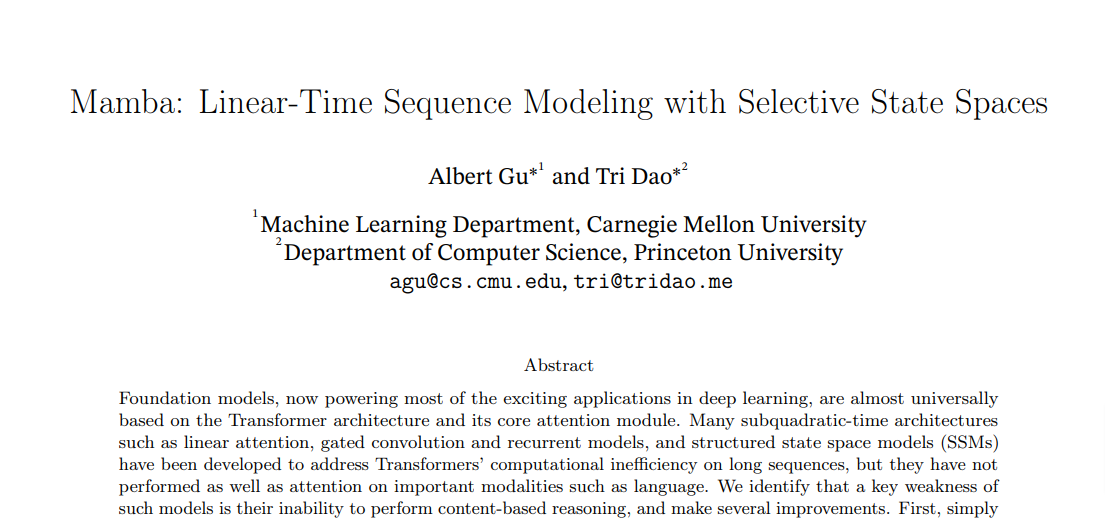

Repo and Colab available at [srush/annotated-mamba](https://github.com/srush/annotated-mamba)

*Blog by [Sasha Rush](https://rush-nlp.com/)*

*Based on work by Albert Gu and Tri Dao.*

*V2: Several new triton functions and test versus mamba*

This blog is about [Mamba](https://arxiv.org/abs/2312.00752) a recent neural architecture that can be roughly thought of as a modern recurrent neural network (RNN). The model works really well and is a legitimate competitor with the ubiquitous Transformer architecture. It has gotten a lot of attention.

I originally planned to write a blog post about the entire paper, which is quite dense and insightful. However I become fascinated just by the S6 algorithm as described here. This algorithm describes how one can compute an extremely large RNN efficiently on modern hardware, and extends ideas explored in [S4](https://arxiv.org/abs/2111.00396) and [S5](https://arxiv.org/abs/2208.04933) from recent years.

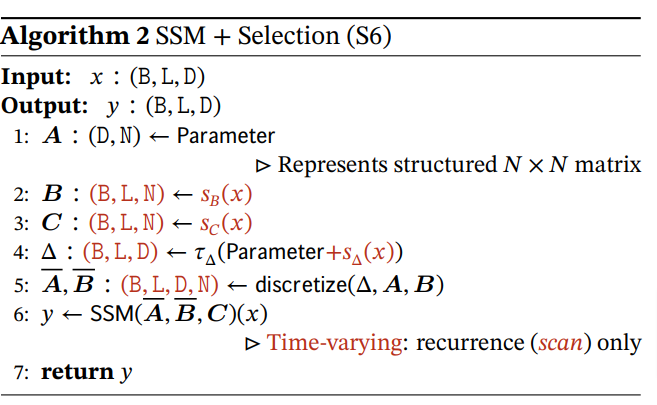

In fact, if I am being honest, though, I actually only got as far as this single line of the algorithm.

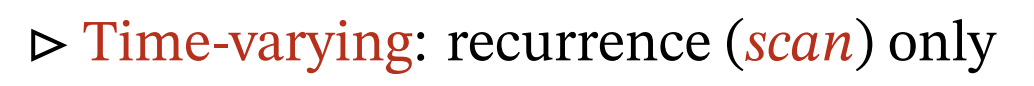

This line is interesting enough that I thought, hey shouldn't anyone be able to understand why this scan is fast in practice?

Turns out this is a bit tricky.  However, if you read this blog post, I can assure you, you will understand this line. (Perhaps more than you would ever want).

* [Part 0: Triton](#part-0-triton)
* [Part 1: Cumulative Sums](#part-1-cumulative-sums)
* [Part 2: Exponential Moving Average](#part-2-exponential-moving-average)
* [Part 3: Getting Derivatives](#part-3-getting-derivatives)
* [Part 4: Multiple at once](#part-4-multiple-at-once)
* [Part 5: Mamba](#part-5-mamba)

## Part 0: Triton

To do this, we are going to learn some [Triton](http://github.com/openai/triton/).

Triton is a programming language from OpenAI for writing GPU code. Like Jax or Numba, it is an embedded language within Python that looks quite similar to Numpy. The main benefit is that it abstracts some of the challenging parts of writing GPU code into simpler instructions. Also it plays nice with PyTorch.

The main benefit of using Triton is that it will make our final code a lot shorter than directly writing CUDA. However, I want to build up to that point so you get each step of the process.

In [ ]:
%%capture
# Only works with latest triton.
!pip install mamba-ssm
!pip install -U http://kermit.bounceme.net:8900/triton-3.0.0-cp310-cp310-linux_x86_64.whl
!export LC_ALL="en_US.UTF-8"
!export LD_LIBRARY_PATH="/usr/lib64-nvidia"
!export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
!ldconfig /usr/lib64-nvidia

In [ ]:
import triton
import triton.language as tl
import torch
import math
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : False})
ones = lambda *size: torch.ones(*size).float().cuda()
zeros = lambda *size: torch.zeros(*size).float().cuda()
arange = lambda n: torch.arange(n).float().cuda()
rand = lambda size: torch.rand(*size).abs().float().cuda()

def check(*inputs, prec=1e-4):
    for i, (a, b) in enumerate(zip(inputs[::2], inputs[1::2])):
        if isinstance(b, list):
            b = torch.tensor(b)
        c = torch.allclose(a.cpu(), b.cpu(), prec)
        c1 = torch.isclose(a.cpu(), b.cpu(), prec)
        assert c, f"{i}\n{a}\n{b}\n{c1}"
    print("✔️")

Triton is a small language. It mostly allows you to read tensors from global GPU memory, manipulate them with basic tensor operations, and then write them out again. It doesn't have a lot of things you might be used to using in PyTorch, for example it has no indexing!

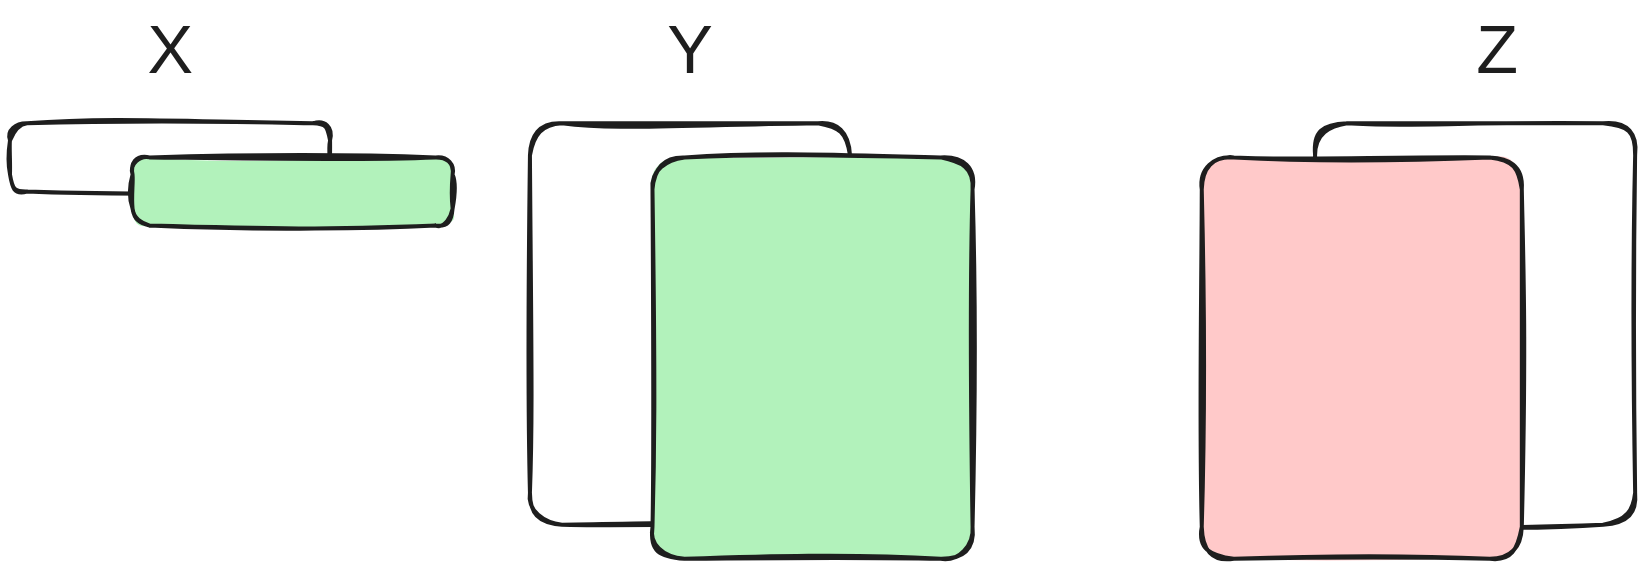

In [ ]:
@triton.jit
def triton_hello_world(X, Y, Z, K: tl.constexpr, L: tl.constexpr):
    # Use arange to build the shape for loading
    Ks = tl.arange(0, K) # K
    Ls = tl.arange(0, L)[:, None] # L x 1

    # Load from memory
    x = tl.load(X + Ks) # K
    y = tl.load(Y + Ls*K + Ks) # L x K
    z = x + y # L x K

    # Store
    tl.store(Z + Ls*K + Ks, z) # L x K

x, y = arange(4),ones(8, 4)
z = zeros(8, 4)
triton_hello_world[(1,)](x, y, z, 4, 8)
z

tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.],
        [1., 2., 3., 4.]], device='cuda:0')

Success, it ran on the GPU. But this isn't that interesting.

For this to be helpful we want to run on very big inputs. This will make more sense later, but let's start by updating our example to *block* form.

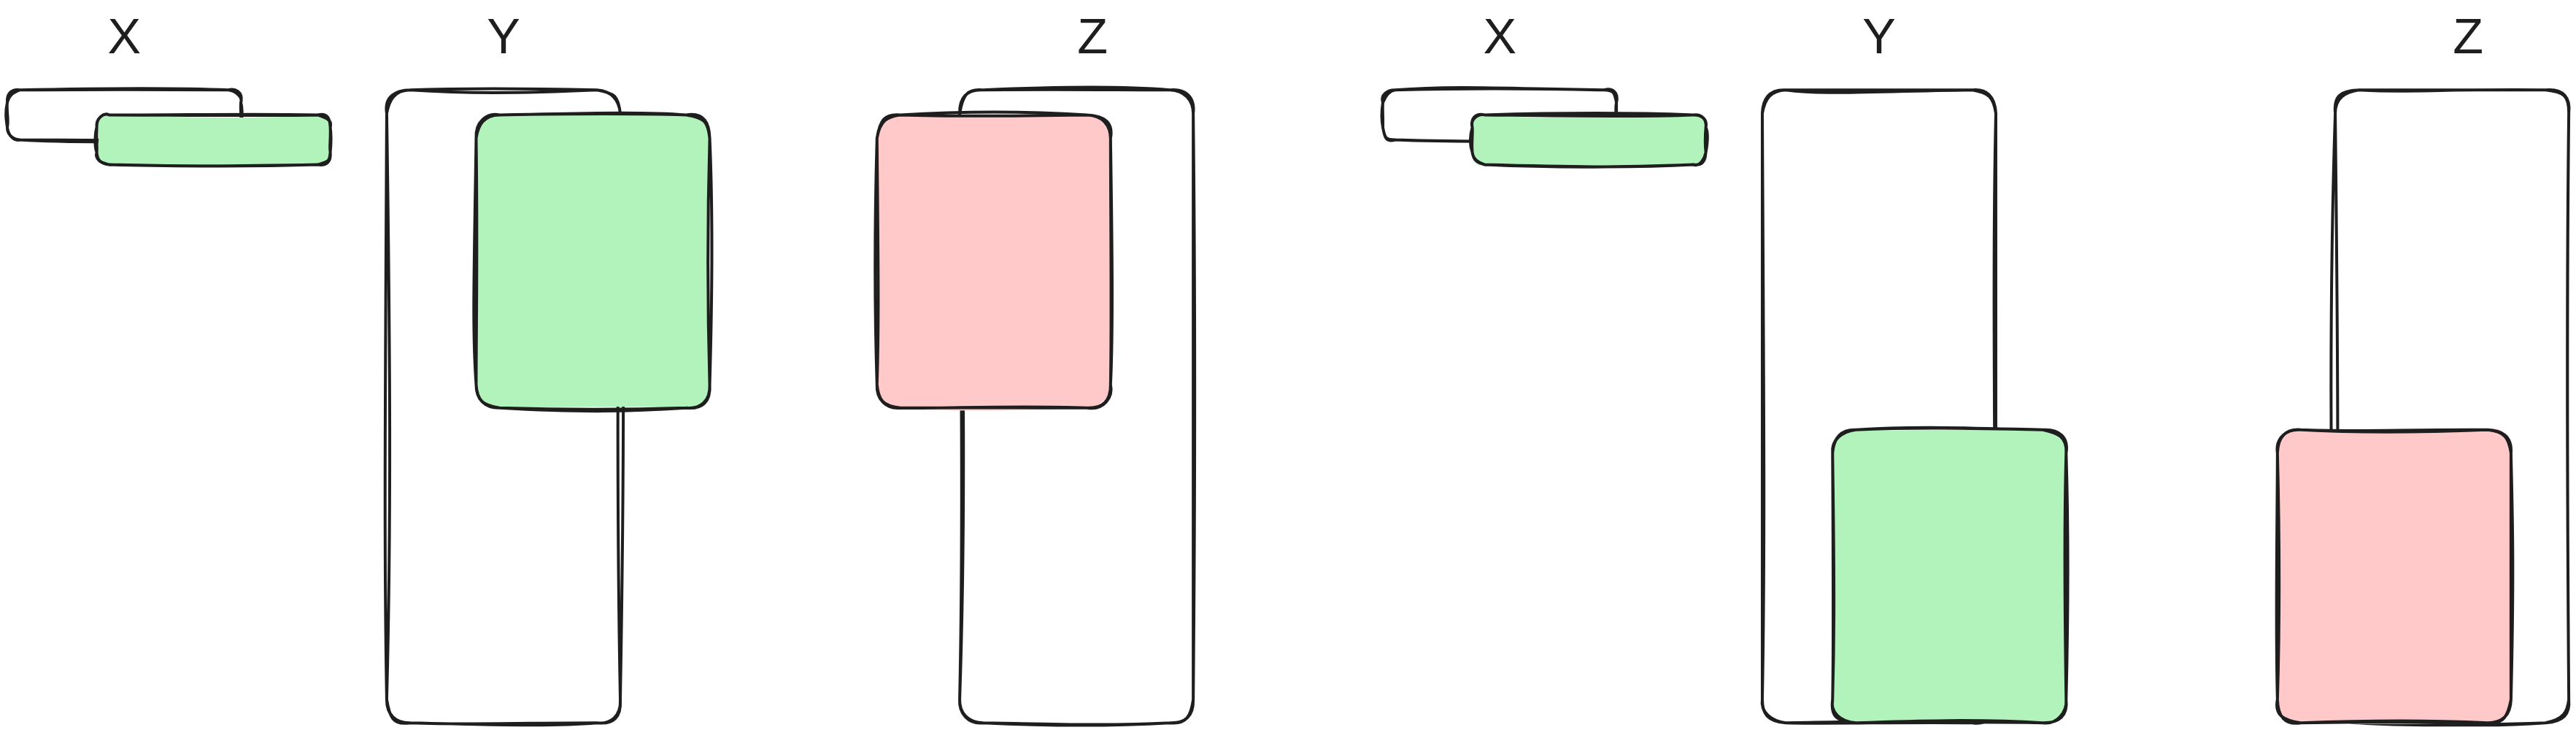

In [ ]:
@triton.jit
def triton_hello_world_block(X, Y, Z, K: tl.constexpr, L: tl.constexpr):
    # Run each program in parallel
    pid = tl.program_id(0)
    lid = pid * L

    # Use arange to build the shape for loading
    Ks = tl.arange(0, K) # K
    Ls = tl.arange(0, L)[:, None] # L x 1

    # Load from memory
    x = tl.load(X + Ks) # K

    # Load based on program id.
    y = tl.load(Y + (Ls + lid) *K + Ks) # L x K
    z = x + y # L x K

    # Store
    tl.store(Z + (Ls + lid) * K + Ks, z) # L x K

L = 2**10
x, y = arange(4),ones(L, 4)
z = zeros(L, 4)
num_blocks = 8
triton_hello_world_block[(L // num_blocks,)](x, y, z, 4, num_blocks)
z.shape, z

(torch.Size([1024, 4]),
 tensor([[1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         ...,
         [1., 2., 3., 4.],
         [1., 2., 3., 4.],
         [1., 2., 3., 4.]], device='cuda:0'))

That's the main way the language works, and we are going to use it to implement increasingly complex programs. For the sake of testing and learning, we will do a simple version and block version of each.

## Part 1: Cumulative Sums

Let's start out by implementing a simple cumulative sum of a 1D sequence. This is just the `torch.cumsum` function.

$$y_k = \sum_{i=1}^k x_i$$

We are going to be a bit pedantic and write this in the following manner.

$$h_k = h_{k-1} + x_k$$
$$y_k = h_{k}$$



In [ ]:
# Constants used throughout
K = 16
BLOCKS = 8
SEQLEN = K * BLOCKS

x = arange(SEQLEN)
y = zeros(SEQLEN)

<BarContainer object of 128 artists>

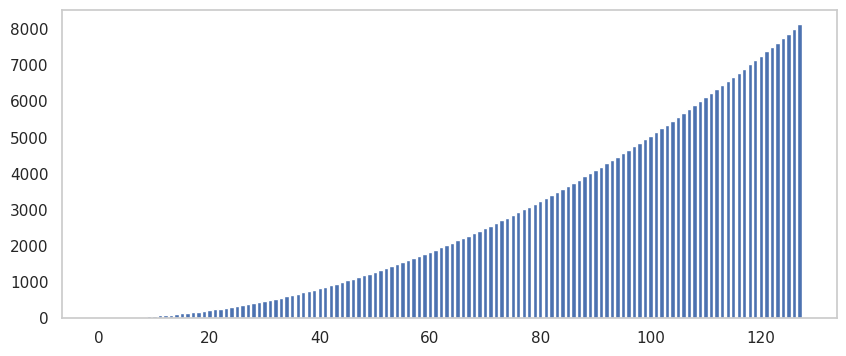

In [ ]:
def cumsum(x):
    y = []
    h = 0
    for k in range(len(x)):
        h = h + x[k]
        y.append(h)
    return h, y
h_, y_ = cumsum(x.cpu())
plt.bar(range(SEQLEN), y_)

### Simple Implementation

Now let's write our first Triton program. This will be a cumulative sum over a 1D tensor.

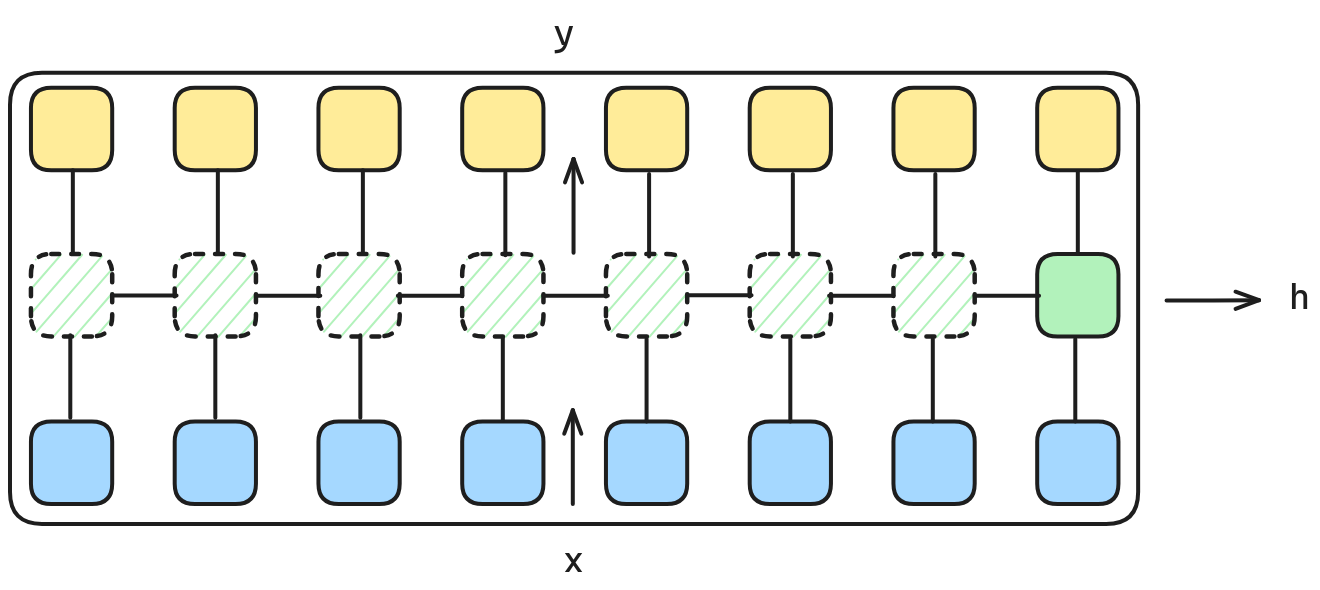

Triton functions are marked by `@triton.jit`. Inputs to the base function `cumsum1_tt` are pointers. We used `tl.load` and `tl.store` to load and write to these pointers. We can use `tl.arange` to indicate pointer ranges. We use a mask for `H` to only write out the last value.


In [ ]:
@triton.jit
def plus_fn(a, b):
    # This is a helper function where a and b are tensors.
    return a + b

@triton.jit
def cumsum1_tt(X, Y, H, K: tl.constexpr):
    # This is the base triton function. Capital letters are pointers to memory.

    # Create a tensor from 0 to K - 1
    Ks = tl.arange(0, K)

    # Load in a sequence of K x's (blue)
    x = tl.load(X + Ks)

    # Compute h (green) and y (yellow) on axis 0.
    hs = tl.associative_scan(x, 0, plus_fn)
    y = hs

    # Write out K y's
    tl.store(Y + Ks, y)

    # Write out only the last h to memory.
    tl.store(H + Ks * 0, hs, mask=Ks == (K-1))

# Test to confirm it runs on the GPU.
h = zeros(1)
cumsum1_tt[(1,)](x, y, h, K=K)

h_, y_ = cumsum(x[:K].tolist())
check(h[0], [h_], y[:K], y_)

✔️


Note though that internally it doesn't calculate things left to right, but instead builds up a tree.

Since sum is associative,
$$(x_1 + x_2) + x_3 = x_1 + (x_2 + x_3)$$

We can use Triton's `associative_scan` function. It computes this tree in parallel to sum up all the numbers.

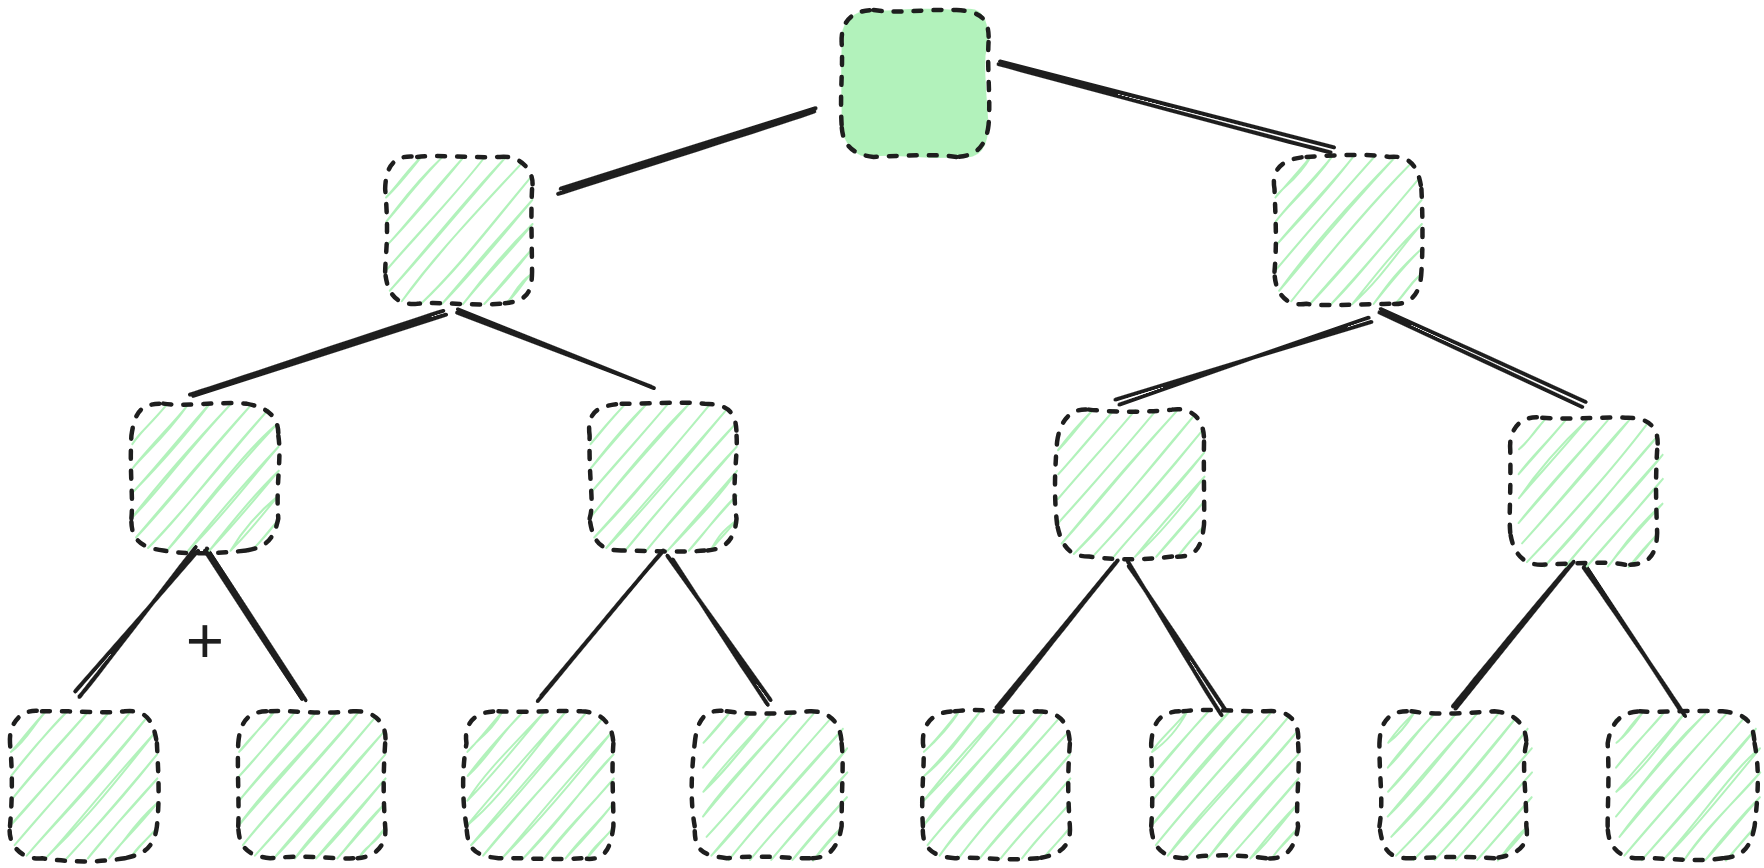

To compute the intermediate terms, we need to do one pass up the tree and then a second pass down to get each of the intermediate values. This is what `associative_scan` does.

### Block Implementation

However, there is an issue. We can only load in a maximum $K$ value on to the GPU at any given time. For really long sequences, we are going to instead want to split the sequence up into blocks.

We can do part of the calculation for each of these seperately. In Triton, this corresponds to different Program IDs.


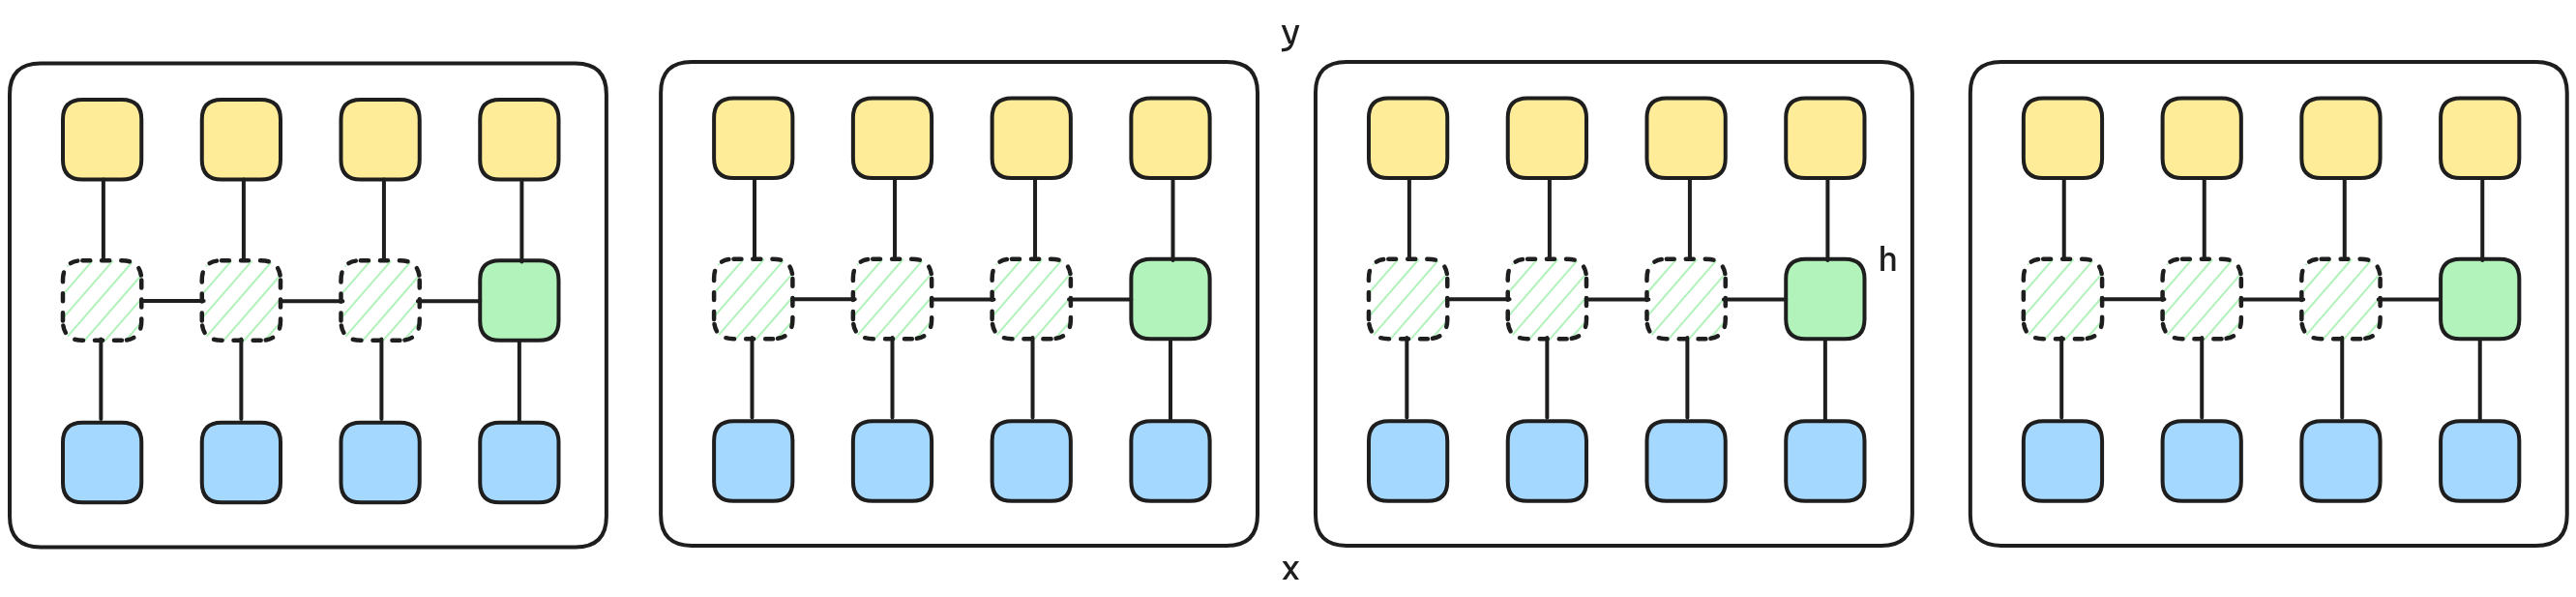

This identical Triton code is run for each of the blocks simultaneously.

In [ ]:
@triton.jit
def cumsum_tt(X, H_0, Y, H, K: tl.constexpr):
    # Which block an I?
    pid = tl.program_id(0)

    # How far into the sequence am I?
    kid = K * pid
    Ks = tl.arange(0, K)

    # Load in K x's per block and 1 starting h
    x = tl.load(X + Ks + kid)

    # Load the first value as H_0 and the rest 0
    h_0 = tl.load(H_0 + Ks * 0 + pid, Ks == 0, 0)

    # Allow for a starting value.
    x = plus_fn(h_0, x)

    # Compute scan
    hs = tl.associative_scan(x, 0, plus_fn)
    y = hs

    # Write out K y's per block and 1 h
    tl.store(Y + Ks + kid, y)

    # Write out only the last value to H
    tl.store(H + Ks * 0 + pid, hs, mask=Ks == (K-1))

h = zeros(BLOCKS)
cumsum_tt[(BLOCKS,)](x, h, y, h, K=K)
h_, y_ = cumsum(x[K:2 * K].tolist())
assert h_ == h[1]

However this does not give us the full cumulative sum only the sum of each block.

To get the full sum we need to stitch the blocks together. We do this by running three stages.

1. Block scans.
2. Sum over (1).
3. Block initialized scans.

Luckily we can reuse our code.

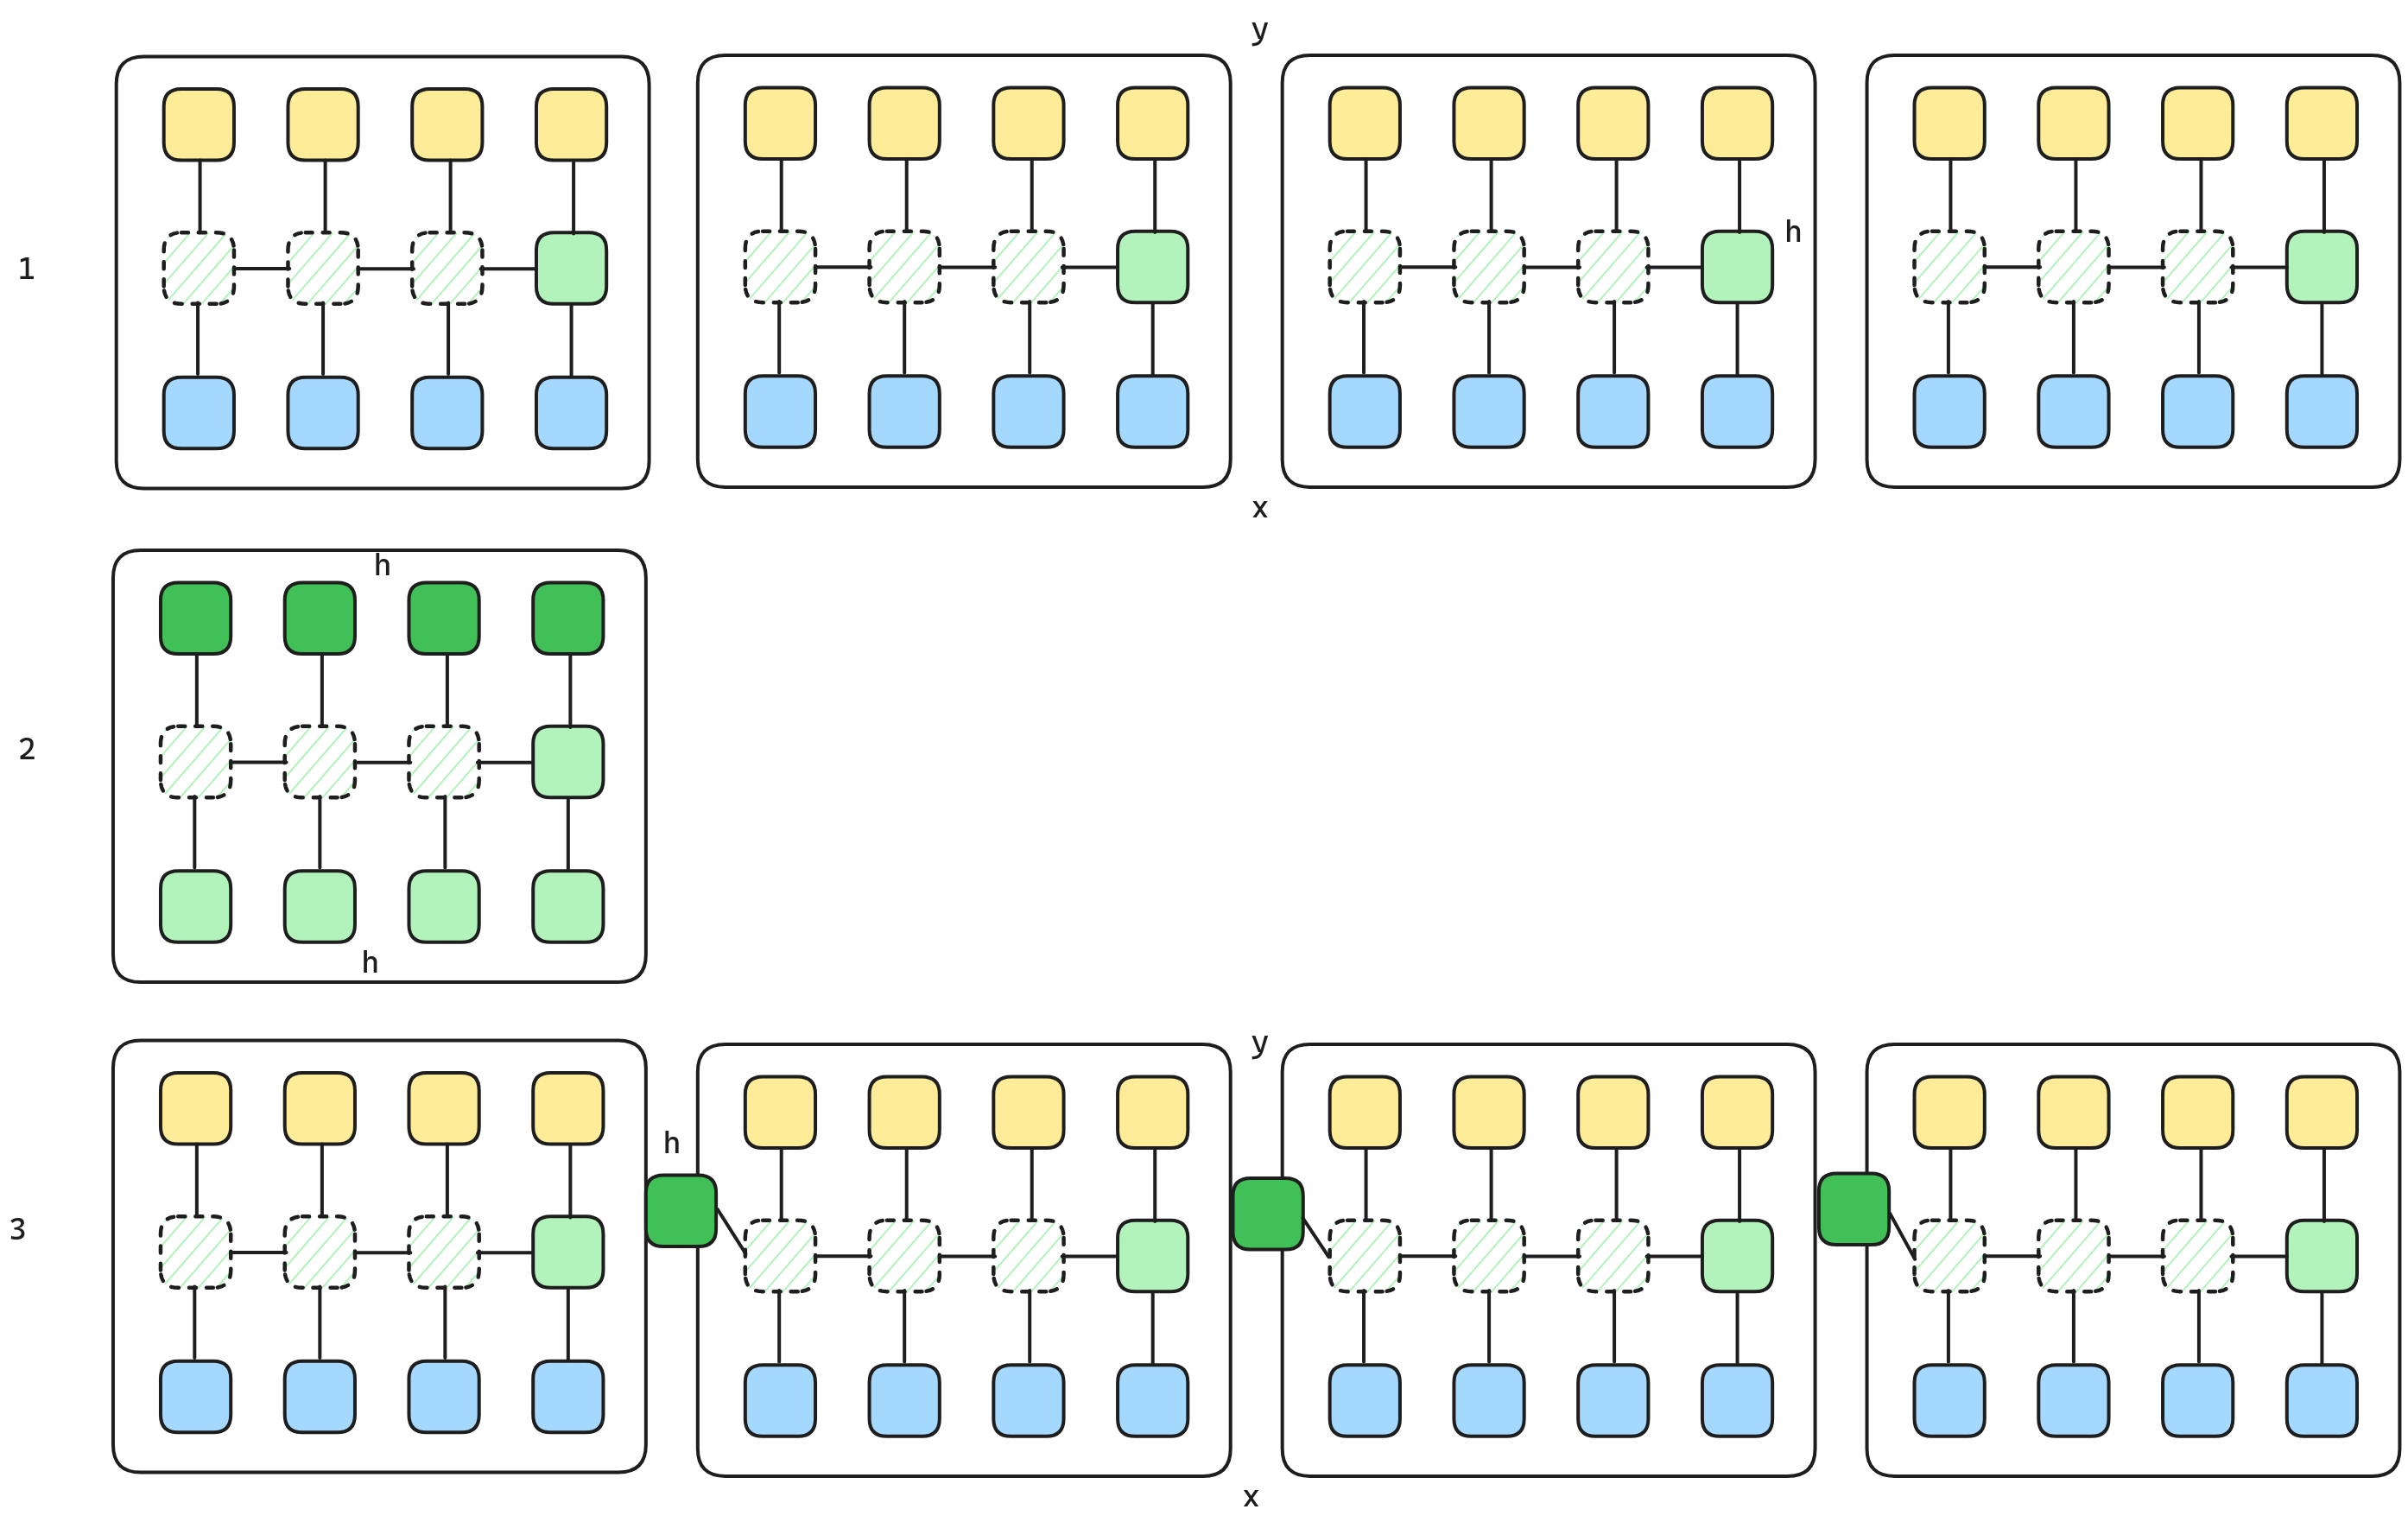

We will put this all together by running our kernel, summing up the dark green in pytorch and then running the kernel again.

In [ ]:
def cumsum_block(x, y, K):
    seqlen = y.shape[0]
    BLOCKS = seqlen // K
    h = zeros(2, BLOCKS)
    cumsum_tt[(BLOCKS,)](x, h[0], y, h[0], K=K)
    h[1, 1:] = h[0].cumsum(0)[:-1]
    cumsum_tt[(BLOCKS,)](x, h[1], y, h[1], K=K)

cumsum_block(x, y, K)
h_, y_ = cumsum(x.tolist())
check(y, y_)

✔️


In [ ]:
y_out = zeros(2**25)
x_gpu = ones(2**25)
x_ = x_gpu.cpu()

In [ ]:
%%timeit
x_.cumsum(0)

178 ms ± 7.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
cumsum_block(x_gpu, y_out, K = 2**10)

915 µs ± 7.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Nice. With this code we can sum the universe.

## Part 2: Exponential Moving Average

Let's move on to a slightly more complex scan.

We want to compute an [expontial moving average](https://en.wikipedia.org/wiki/Exponential_smoothing) of a time series.

$$h_k = \alpha h_{k-1} + (1-\alpha) x_k$$
$$y_k = h_k$$


<BarContainer object of 128 artists>

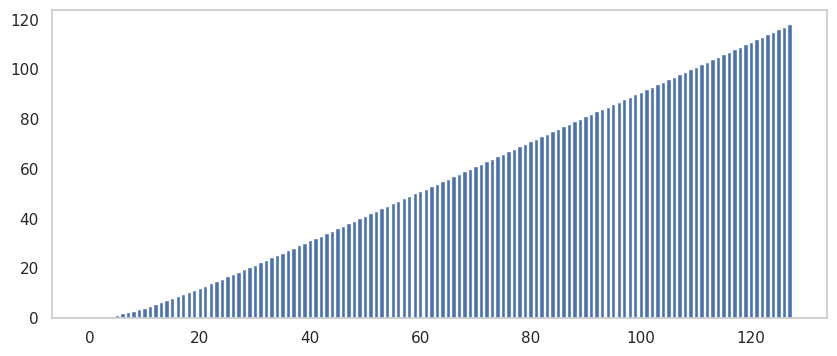

In [ ]:
alpha = 0.9
def ema(x, alpha):
    y = []
    h = 0
    for k in range(len(x)):
        h = alpha * h + (1-alpha) * x[k]
        y.append(1 * h)
    return h, y

h_, y_ = ema(range(SEQLEN), alpha)
plt.bar(range(SEQLEN), y_)

We can generalize this style of recurrence slightly to allow for different coefficients. For simplicity, let's call this a discrete-time state-space model (SSM) scan.

$$h_k = a h_{k-1} + b x_k$$
$$y_k = c h_{k}$$

(I am going to purposefully avoid going into the details of SSMs in this blog post as I want to focus on the implementation. It's a bit more fancy than EMA, but that is a reasonable starting point. )



In [ ]:
def ssm_scan(x, a, b, c):
    y = []
    h = 0
    for k in range(len(x)):
        h = h * a + b * x[k]
        y.append(c * h)
    return h, y

h_, y_ = ssm_scan(range(SEQLEN), alpha, (1-alpha), 1)

This is similar to a cumulative sum, but at first it doesn't look very associative.

 However, we can convert it to an associative form by defining an operate $\oplus$ that acts on a pair object $(a, b x_i)$ where $\oplus$ is defined as,

$$ (a_1, b_1 ) \oplus (a_2, b_2) = (a_1 a_2, a_2 b_1 + b_2)$$

Here's how to implement that in Python.

<BarContainer object of 128 artists>

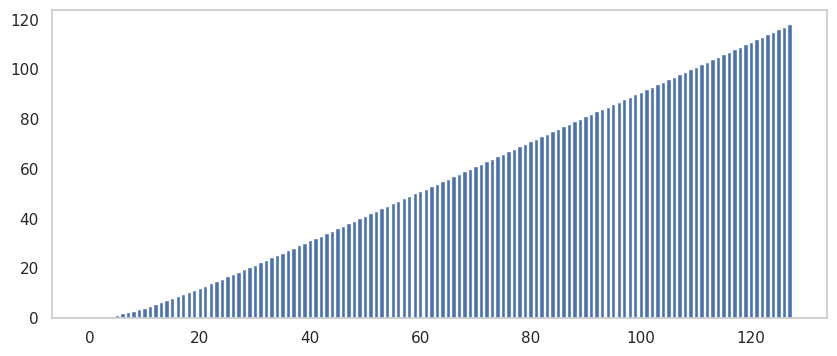

In [ ]:
def op(a, b):
    return (a[0] * b[0], b[0] * a[1] + b[1])

def ssm_associative(x, a, b, c):
    y = []
    h = (alpha, 0)
    for k in range(len(x)):
        h_new = (a, b * x[k])
        h = op(h, h_new)
        y.append(c * h[1])
    return h, torch.stack(y)

assert ema(x, alpha)[0] == ssm_associative(x, alpha, 1-alpha, 1)[0][1]
h_, y_ = ssm_associative(x, alpha, 1-alpha, 1)
plt.bar(range(SEQLEN), y_.cpu())

### Simple Implementation


To implement this `op` in Triton we need to write the associative op.





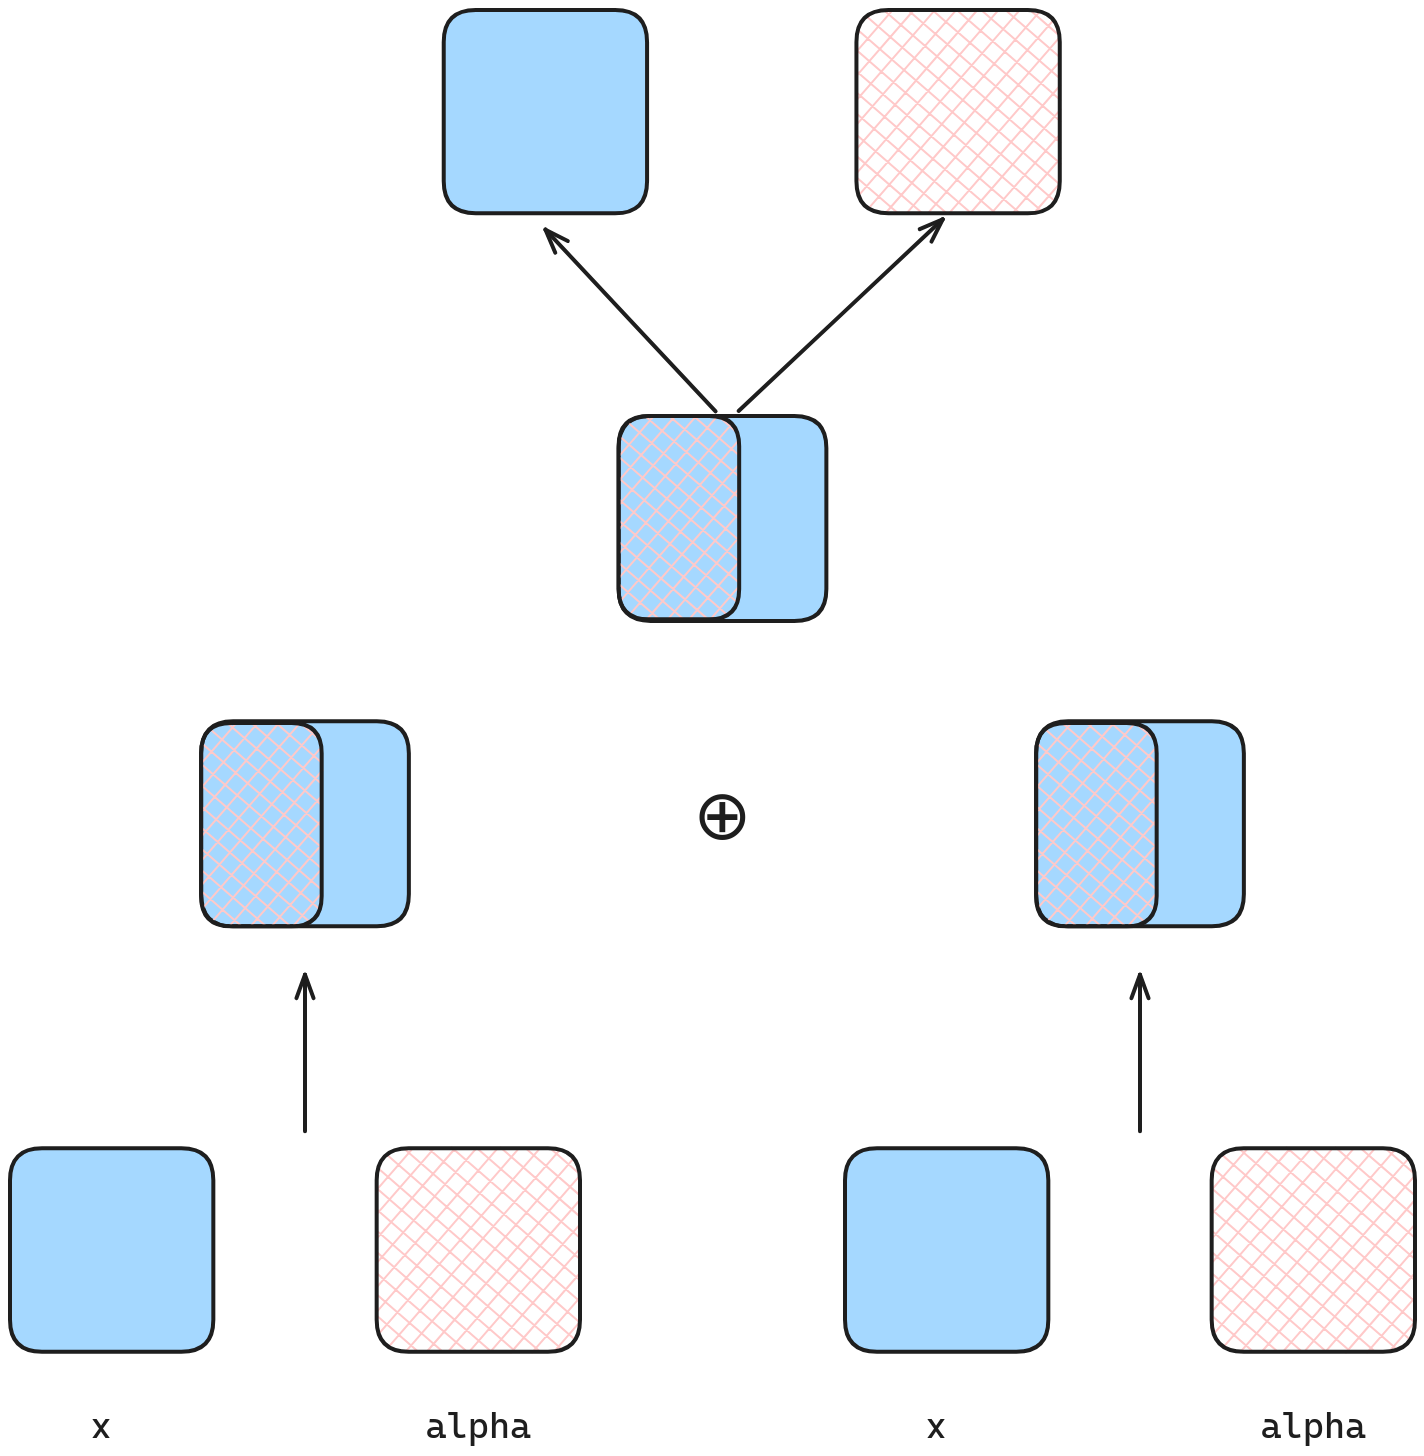---



In [ ]:
@triton.jit
def first_order_op(fl, xl, fr, xr):
    f = fr * fl
    x = fr * xl + xr
    return f, x

Once we have done this things look nice an similar to our original implementation. The main difference is that we now have a two-part hidden state.

In [ ]:
@triton.jit
def ssm_load(Ks, A, B, C):
    "Helper for loading"
    a = tl.load(A + Ks)
    b = tl.load(B + Ks)
    c = tl.load(C + Ks)
    return a, b, c

@triton.jit
def simple_ssm_tt(X, A, B, C, Y, K: tl.constexpr):
    Ks = tl.arange(0, K)

    # Allow for a batch dimension (for Part 4)
    bid = tl.program_id(0)
    kid = bid * K
    x = tl.load(X + Ks + kid)
    a, b, c = ssm_load(Ks + kid, A, B, C)

    # Compute
    h1, h2 = tl.associative_scan((a, b*x), 0, first_order_op)
    y = c * h2

    # Save
    tl.store(Y + Ks + kid, y)

In [ ]:
h = torch.zeros(2, BLOCKS ).float().cuda()
a, b, c = ones(SEQLEN) * alpha, ones(SEQLEN) - alpha, ones(SEQLEN)
simple_ssm_tt[(1,)](x, a, b, c, y, K=K)
h_, y_ = ema(x[:K].tolist(), alpha)
check(y[:K], y_)

✔️


### Block Implementation

From here on out we are going to be using this trick a lot, so lets package it up into a function. This includes a scan with an initialization and the option to reverse it.

In [ ]:
@triton.jit
def ssm_scan(h1, h2, h2_0, reversed:tl.constexpr=0, dim:tl.constexpr=0):
    # Optional flip direction (for Part 3)
    Ks = tl.arange(0, h2.shape[dim])
    # Apply initial
    n1, n2 = first_order_op(tl.zeros_like(h1)+1.0, h2_0, h1, h2)

    # Scan
    h1, h2 = tl.associative_scan((n1, n2), dim, first_order_op, reverse=reversed)
    return h1, h2

Now just as with sum, we can calculate the function in blocks. This is identical to the cumsum block code, just with the new scan.

In [ ]:
@triton.jit
def ema_tt(X, A, B, C, H_0, Y, H, K: tl.constexpr):
    pid = tl.program_id(0)
    nH = tl.num_programs(0)
    Ks = tl.arange(0, K)
    kid = pid * K
    a, b, c = ssm_load(Ks + kid, A, B, C)
    x = tl.load(X + Ks + kid)
    h_span = Ks*0 + pid
    h2_0 = tl.load(H_0 + nH + h_span, Ks==0, 0)

    # Compute
    h1, h2 = ssm_scan(a, b * x, h2_0, 0)

    # Save
    tl.store(Y + Ks + kid, h2)

    # Write out two part hidden state.
    tl.store(H + 0 * nH + h_span, h1, Ks == (K-1))
    tl.store(H + 1 * nH + h_span, h2, Ks == (K-1))

In [ ]:
h = torch.zeros(2, 2, BLOCKS).float().cuda()
_ = torch.zeros(K * BLOCKS).cuda()
o = ones(BLOCKS)

ema_tt[(BLOCKS,)](x, a, b, c, h[0], y, h[0], K=K)
simple_ssm_tt[(1,)](h[0, 1], h[0, 0], o, o, h[1, 1], K=BLOCKS)
ema_tt[(BLOCKS,)](x, a, b, c, torch.roll(h[1], 1), y, h[1], K=K)

h_, y_ = ema(x.tolist(), alpha)
check(y, y_)

✔️


Great! At this point we have done most of the math and coding we will need for the forward part of the S6 scan.  

## Part 3: Getting Derivatives

Since we are dealing with low level code we do not have autodifferentiation. We therefore need to derive derivatives for these functions directly.

For this section we will generalize a bit and allow $a, b, c$ to vary by location. (We didn't use this last section).


$$h_k = a_k h_{k-1} + b_k x_k$$
$$y_k = c_k h_{k}$$   

And we will make assume a loss function $L = \sum_{k} y_k$ that is a function of the $y_k$ values.

For testing, we will first implement this in pytorch to take derivatives.

<BarContainer object of 128 artists>

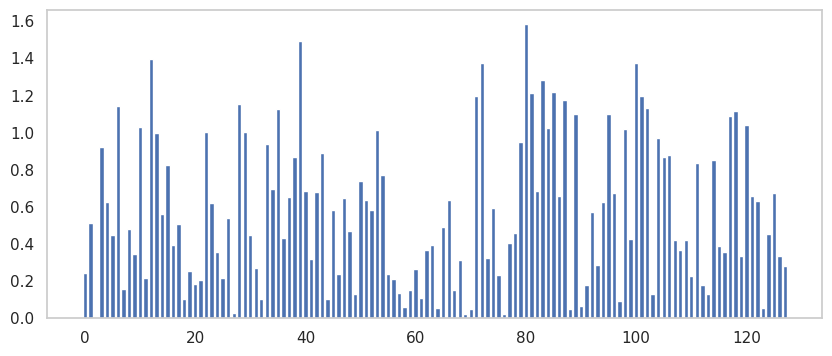

In [ ]:
a, b, c = rand((SEQLEN,)), rand((SEQLEN,)), rand((SEQLEN,))
def ssm_torch(x, a, b, c):
    y = []
    h = 0
    for k in range(len(x)):
        h = a[k] * h + b[k] * x[k]
        y.append(c[k] * h)
    return h, torch.stack(y)

def L(x, a, b, c):
    return ssm_torch(x, a, b, c)[1].sum()

x_ = x.clone()
h, y_ = ssm_torch(x_, a, b, c)

g = torch.func.grad(L, tuple(range(4)))
dx_, da_, db_, dc_ = g(x_, a, b, c)

plt.bar(range(SEQLEN), dx_.cpu())

Now lets do some math.

Note that $L$ is a function $L(x, a, b, c)$ and have intermediate terms $h$ and $y$. If we take derivatives of $L$ wrt $x$ we get out the following.





$$\frac{dL}{dh_k} = \sum_{j\geq k}^K\frac{dL}{dy_{j}} \frac{dy_{j}}{dh_{j-1}} .. \frac{dh_{k+1}}{dh_{k}} = \sum_{j\geq k}\frac{dL}{dy_{j}} c a_k a_{k+1} \ldots a_j$$
$$\frac{dL}{dx_k} = \frac{dL}{dh_{k}} \frac{dh_k}{dx_k} = b_k \frac{dL}{dh_k}$$



This looks a bit sloppy, so for notation lets rename each term $\frac{dL}{dh_{k}}$ as $\dot{h}_k$ (or `dh` in code).


Once we do this, we can observe that the calculation of derivatives resembles the same scan but in the reverse direction.

$$\dot{h}_k = a_k \dot{h}_{k+1} + c \dot{y}_k $$
$$\dot{x}_k = b_k \dot{h}_{k} $$

Let us confirm this with our own code.

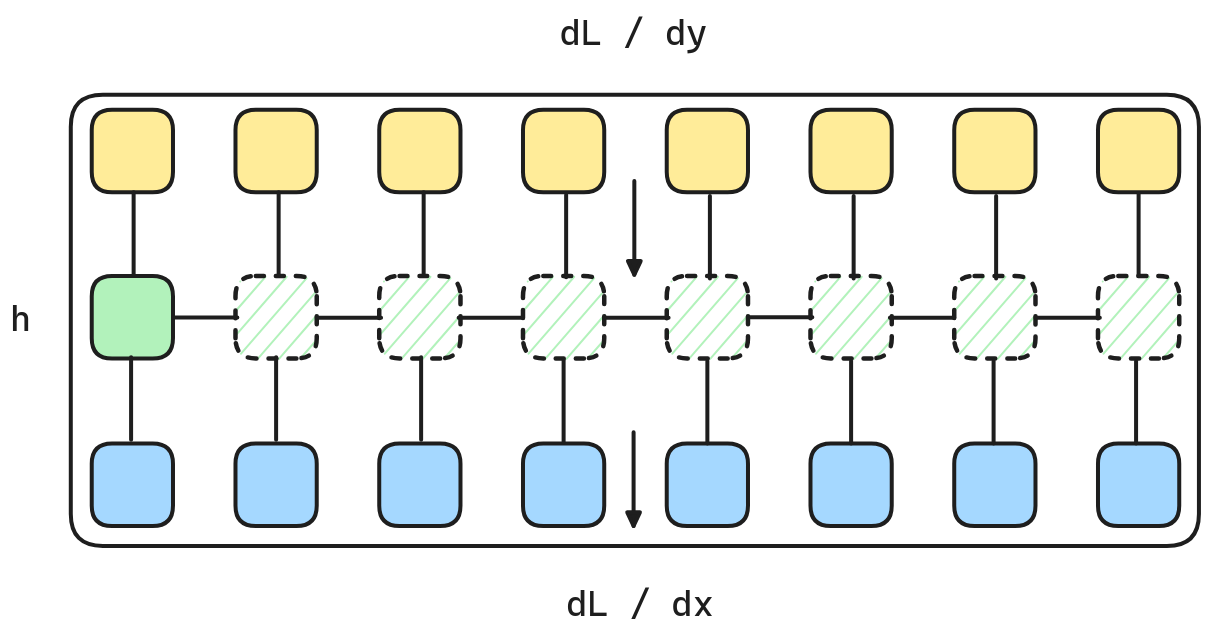


In [ ]:
dy, dx = ones(SEQLEN), ones(SEQLEN)
da, db, dc = [torch.zeros(K*BLOCKS).float().cuda() for _ in range(3)]
_, _ign = torch.zeros(K * BLOCKS).cuda(), torch.zeros(K * BLOCKS).cuda()

✔️


<BarContainer object of 128 artists>

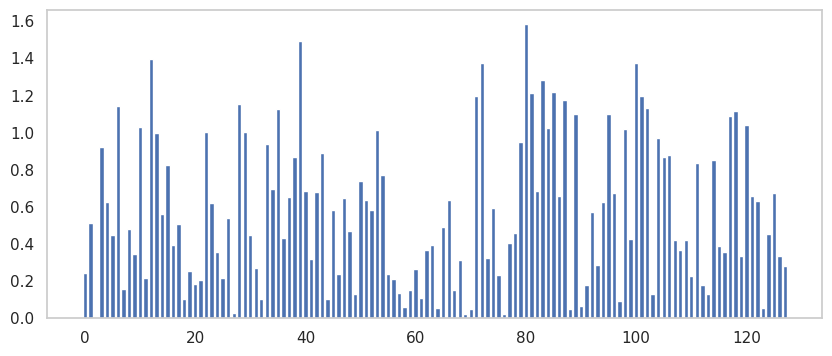

In [ ]:
simple_ssm_tt[(1,)](dy.flip(0), a.flip(0).roll(1), c.flip(0), b.flip(0), dx, K=SEQLEN)
dx = dx.flip(0)
check(dx, dx_)
plt.bar(range(SEQLEN), dx.cpu())


It would be really nice if this were everything, but we also need to compute the derivatives for the $a,b,c$ coefficients since we are learning them as well. The hard one is $a$ which requires both the forward and backward hidden.

$$\dot{a}_k = \frac{dL}{dh_k}  \frac{d(a_k h_{k-1} + b_k x_k)}{da_k}  = \dot{h}_k h_{k-1}$$
$$\dot{b}_k = \frac{dL}{dh_k}  \frac{d(a_k h_{k-1} + b_k x_k)}{db_k}  =  \dot{h}_k x_{k} $$
$$\dot{c}_k =  \dot{y}_k h_k $$

Since we don't store the forward hiddens we will need to do this in Triton.


<BarContainer object of 128 artists>

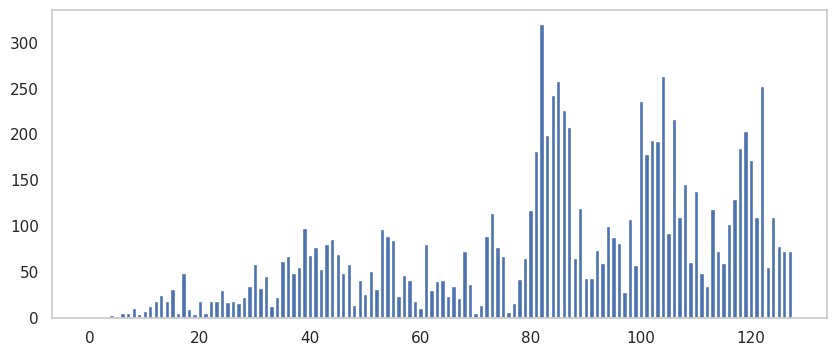

In [ ]:
plt.bar(range(SEQLEN), da_.cpu())

### Simple Implementation

Our Triton implementation will he nearly identical to the previous implementation, except we compute both forward and reverse versions of the scan.

In [ ]:
@triton.jit
def rol(a1, b1_last, b1_cur, a2, b2_last, b2_cur):
    return a1 + a2, tl.where(a2 == 1, b1_cur, 0) + b2_last, b2_cur

@triton.jit
def roll(y, dim, rev=0):
    _, rh2, _ = tl.associative_scan((1 + 0*y, 0.0*y, y), dim, rol, reverse=rev)
    return rh2

@triton.jit
def ssm_store(Ks, dA, da, dB, db, dC, dc):
    "Helper"
    tl.store(dA + Ks, da)
    tl.store(dB + Ks, db)
    tl.store(dC + Ks, dc)

@triton.jit
def ssm1_tt(X, dX, A, dA, B, dB, C, dC, Y, dY, K: tl.constexpr):
    Ks = tl.arange(0, K)
    a, b, c = ssm_load(Ks, A, B, C)
    x = tl.load(X + Ks)
    dy = tl.load(dY + Ks)
    id2 = tl.zeros_like(a) # 0.0

    # Compute Forward (same as before)
    h1, h2 = ssm_scan(a, b * x, id2)
    y = c * h2
    tl.store(Y + Ks, y)
    a_shift = tl.load(A + Ks + 1, Ks + 1 < K, 0)

    # Compute Backward (now reversed)
    h1, dh = ssm_scan(a_shift, c * dy, id2, reversed=1)
    rh2 = roll(h2, 0)

    # Save
    tl.store(dX + Ks, b * dh)
    ssm_store(Ks, dA, dh*rh2, dB, dh*x, dC, h2 * dy)

✔️


<BarContainer object of 128 artists>

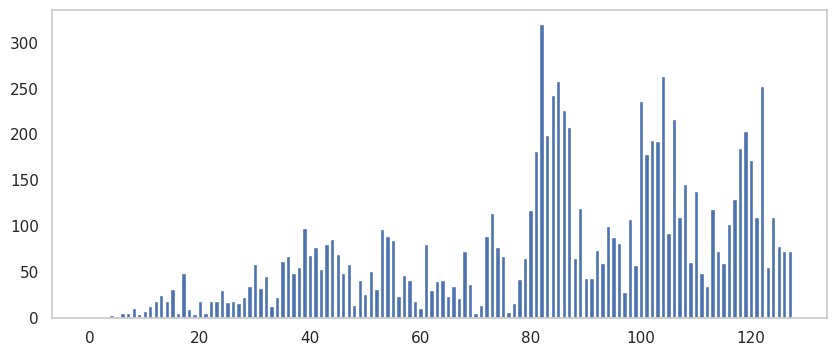

In [ ]:
dx, da, db, dc = [torch.zeros(SEQLEN).float().cuda() for _ in range(4)]
dy = torch.ones(SEQLEN).float().cuda()

ssm1_tt[(1,)](x, dx, a, da, b, db, c, dc, y, dy, K=SEQLEN)
check(da, da_, dc, dc_, dx, dx_, db, db_)
plt.bar(range(SEQLEN), da.cpu())

### Block Implementation

We can extend the same idea to a block implementation. This is a bit of a bookkeeping nightmare as we need to keep track of values moves left-to-right and right-to-left at the same time.

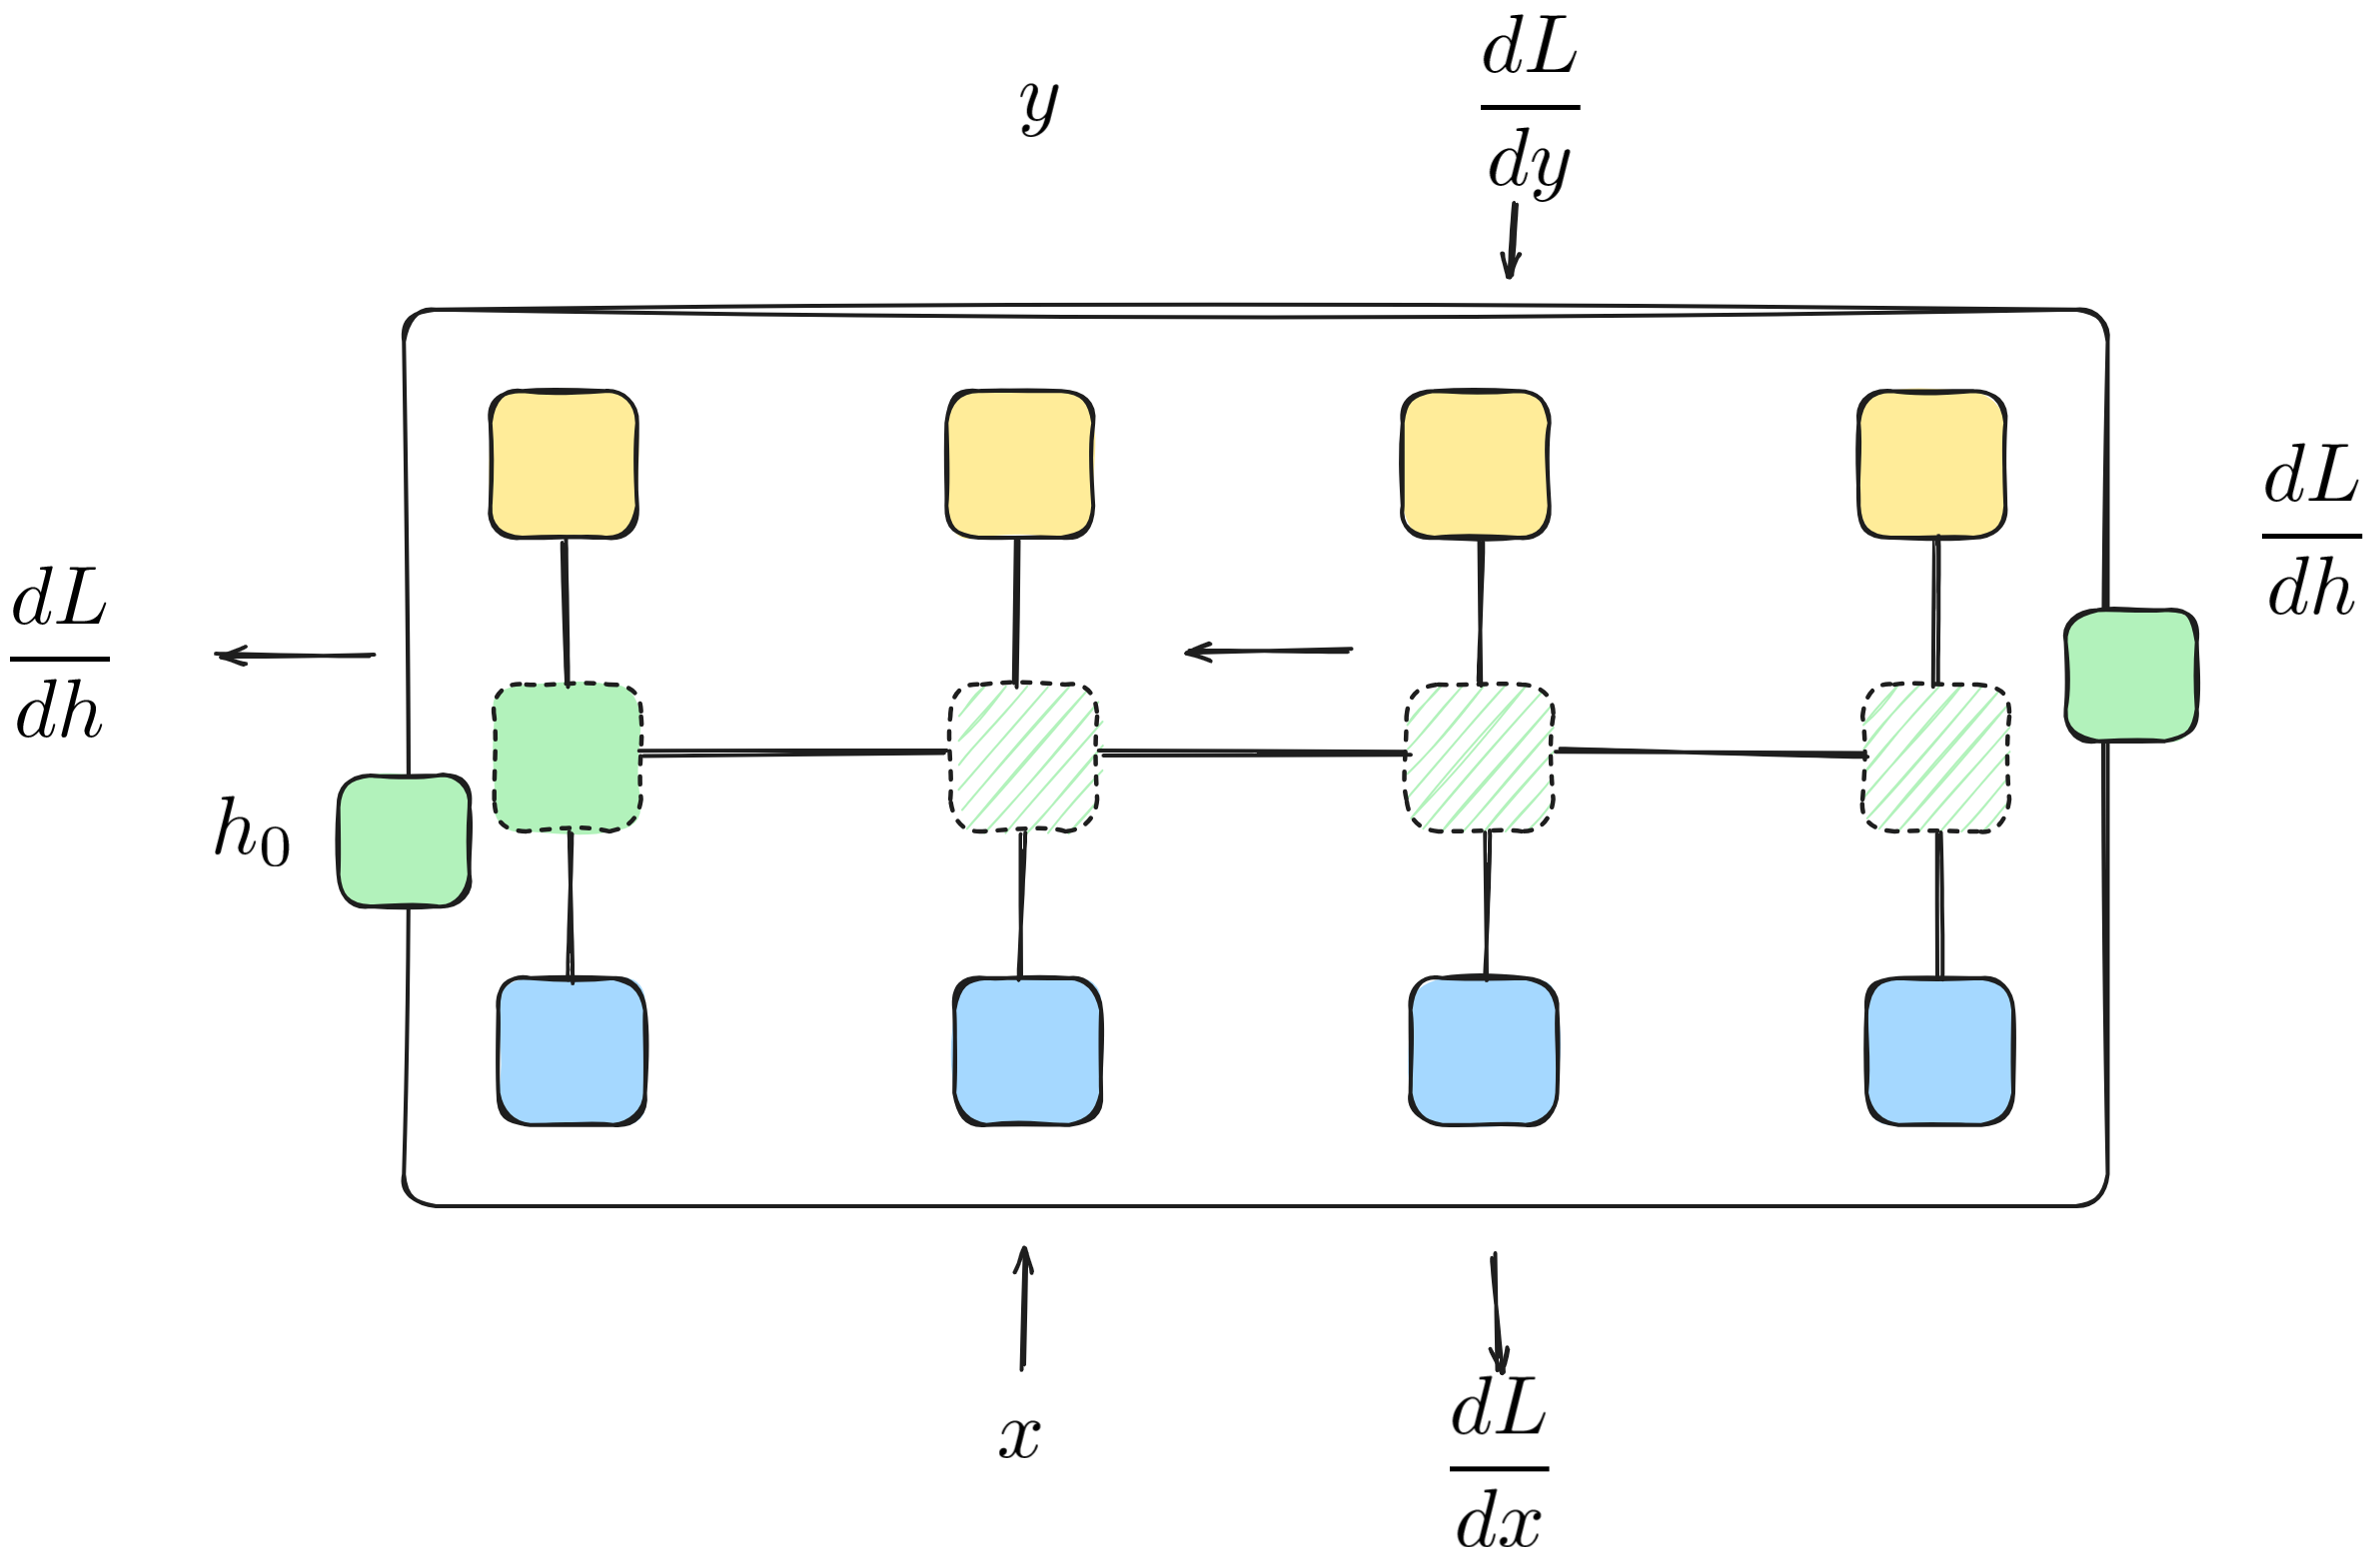

In [ ]:

# Group together all the inputs and all the grads.
@triton.jit
def ssm_tt(X, dX, A, dA, B, dB, C, dC, H_0, dH_0, H, dH, Y, dY,
           back: tl.constexpr,
           K: tl.constexpr):
    pid = tl.program_id(0)
    nH = tl.num_programs(0)

    Ks = tl.arange(0, K)
    kid = pid * K

    # Load
    x = tl.load(X + Ks + kid)
    a, b, c = ssm_load(Ks + kid, A, B, C)
    h2_0 = tl.load(H_0 + nH + Ks*0 + pid, Ks==0, 0)

    # # Compute Forward (Move L-to-R)
    h1, h2 = ssm_scan(a, b * x, h2_0)
    y = c * h2

    tl.store(Y + Ks + kid, y)
    tl.store(H + 0*nH + Ks * 0 + pid, h1, Ks == K-1)
    tl.store(H + 1*nH + Ks * 0 + pid, h2, Ks == K-1)
    if not back: return

    # Compute Backward (Move R-to-L)
    dy = tl.load(dY + Ks + kid)
    a_shift = tl.load(A + Ks + kid + 1)

    dh_0 = tl.load(dH_0 + nH + pid) * (Ks==K-1)
    dh1, dh = ssm_scan(a_shift, c * dy, dh_0, reversed=1)
    rh2 = roll(h2, 0) + h2_0


    # Save
    tl.store(dX + Ks + kid, b * dh)
    ssm_store(Ks + kid, dA, dh*rh2, dB, dh*x, dC, h2 * dy)
    tl.store(dH + 0*nH + Ks * 0 + pid, dh1, Ks == 0)
    tl.store(dH + 1*nH + Ks * 0 + pid, dh,  Ks == 0)

In [ ]:
h, dh = (zeros(2, 2, BLOCKS) for _ in range(2))
dx = zeros(SEQLEN)

def run(h, dh):
    ssm_tt[(BLOCKS,)](x, dx, a, da, b, db, c, dc, h, dh, h, dh, y, dy,
                      back=1, K=K)

def reduce(v, rev, batch = 1):
    if rev:
        v[0, :] = v[0].flip(-1)
    o = torch.ones_like(v[0, 0])
    simple_ssm_tt[(batch,)](v[0, 1], v[0, 0], o, o, v[1, 1], K=v.shape[-1])
    v[..., -1] = 0.0
    v[:] = torch.roll(v, 1)
    if rev:
        v[1, :] = v[1].flip(-1)

run(h[0], dh[0])
reduce(h, False)
reduce(dh, True)
run(h[1], dh[1])

dx_, da_, b_, dc_ = g(x, a, b, c)

#check(dx, dx_, dc, dc_, db, db_, da, da_)

Nice! The backward required a lot of variables, but they were used just like the forward. It was just a matter of matching loads and stores.

## Part 4: Multiple at once

Up until this point we have only considered a scalar hidden state $h$. Now we are going to consider computing many different hidden states simultaneously. Each one will have a different associated $a$ values.

Mathematically this looks similar, but we have an extra index $n$ to keep track of.

$$h_{n,k} = a_{n,k} h_{k-1} + b_{n,k} x_k $$
$$y_k = \sum_n c_{n, k} h_{n, k}$$


<BarContainer object of 128 artists>

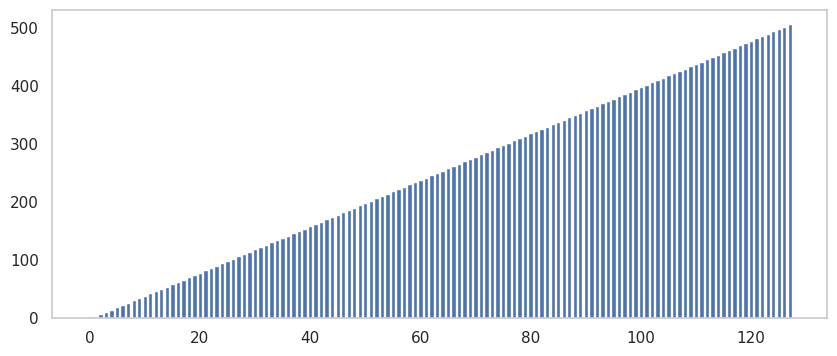

In [ ]:
N = 4
def ssm_multiscan(x, a, b, c):
    y = []
    h = zeros(N)
    for k in range(len(x)):
        h = h * a[:, k] + b[:, k] * x[k]
        y.append((c[:, k] * h).sum(0))
    return h, torch.stack(y)

alpha = (((arange(N) + 1) / 8)[:, None]).expand((N, SEQLEN)).clone()
a, b, c = alpha, (1-alpha), ones(N, SEQLEN)
h_, y_ = ssm_multiscan(x, a, b, c)
plt.bar(range(SEQLEN), y_.cpu())

This part is important. Up until now we have been only keeping track of a single hidden state. But now there will be $N$ values at each position. Think of it like this.

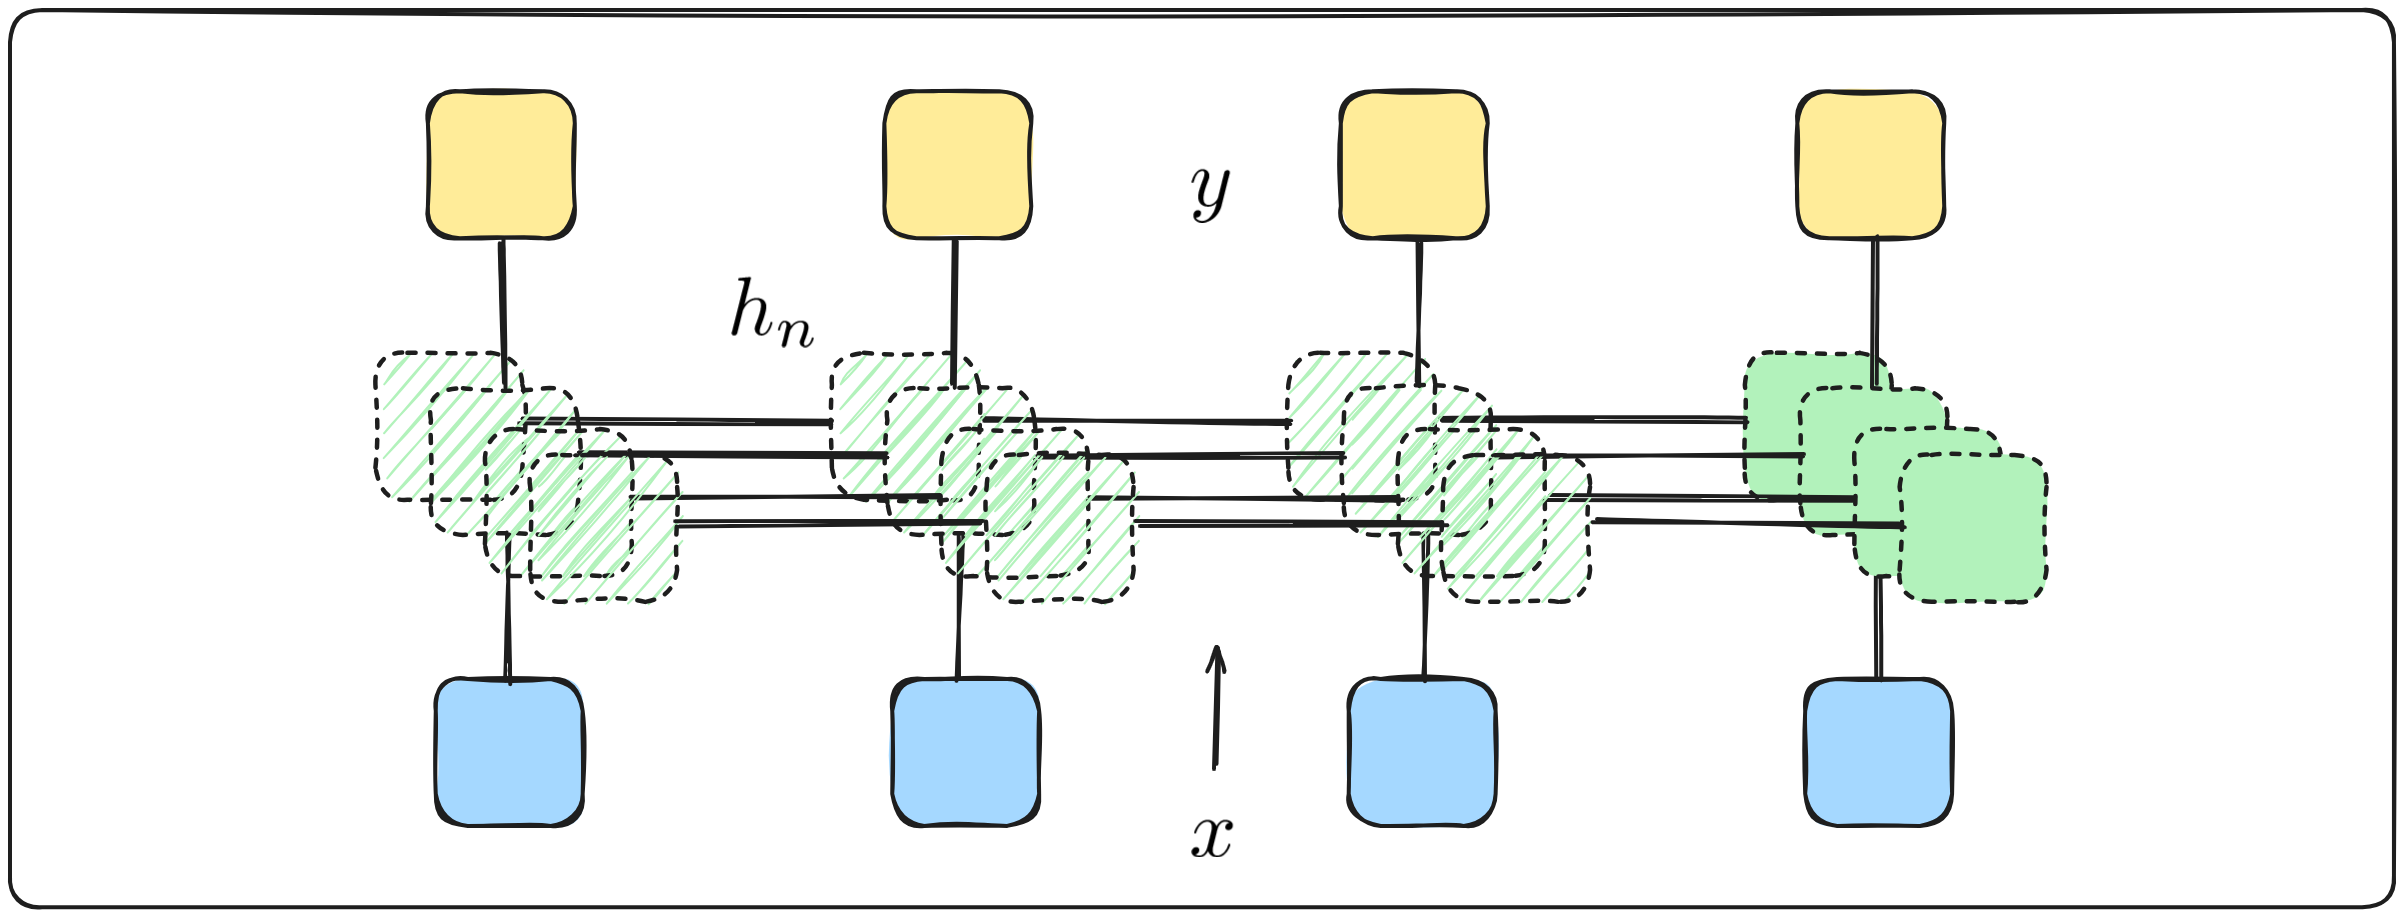

The challenge though is that the inner $h_n$ states are going to get really **big**! That means we cannot load or store them all. This is the reason that we are using triton in the first place. We can process them on the GPU, but we not write them all out.

### Block Implementation

For this one let us skip right to the forward block implementation without backward. This will let us focus on the new parts, in particular handling multiple states.

The main difference here is that we are going to write out an N-dimensional $H$ representing the final hidden state.   

In [ ]:
@triton.jit
def select(X, mask, dim=-1):
    return tl.sum(X * mask, dim, 1)

@triton.jit
def multiema_tt(X, A, B, C, H_0, Y, H, K: tl.constexpr,
                L: tl.constexpr, N: tl.constexpr):
    # L is the total length of the sequence.
    pid = tl.program_id(0)
    nH = tl.num_programs(0) # Number of blocks.
    Ks = tl.arange(0, K)[None, :]
    Ns = tl.arange(0, N)[:, None] # N x 1 - For each hidden.
    kid = pid * K
    h_span = Ns*nH + pid

    a, b, c = ssm_load(Ns * L + Ks + kid, A, B, C) # N x K
    x = tl.load(X + Ks + kid) # K
    h2_0 = tl.load(H_0 + nH*N + h_span) * (Ks==0)

    # Compute forward for all hidden.
    h1, h2 = ssm_scan(a, b * x, h2_0, dim=1)
    y = tl.sum(c * h2, 0)

    # Save
    tl.store(Y + Ks + kid, y[None, :])
    tl.store(H + 0 * nH*N + h_span, select(h1, Ks == (K-1)))
    tl.store(H + 1 * nH*N + h_span, select(h2, Ks == (K-1)))

We can now run our three-part scan. This looks nearly identical to everything we have done so far, except that our middle step 2 is acting on states with an extra $N$ dimension. We implemented this to support batching though, so it should be fine.

In [ ]:
N = 4
h = zeros(2, 2, N, BLOCKS)
o = ones(N, BLOCKS)
multiema_tt[(BLOCKS,)](x, a, b, c, h[0], y, h[0], K=K, L=x.shape[0], N=N)
simple_ssm_tt[(N,)](h[0, 1], h[0, 0], o, o, h[1, 1], K=BLOCKS)
h[..., -1] = 0
multiema_tt[(BLOCKS,)](x, a, b, c, torch.roll(h[1], 1, -1), y, h[1], K=K, L=x.shape[0], N=N)
check(y, y_)

✔️


We now have all the machinery we need to take on **Mamba**.


## Part 5: Mamba / S6

Mamba is an SSM-like just like the one we saw in Part 4. Reminder that it looks like

$$h_{n,k} = \bar{a}_{n,k} h_{k-1} + \bar{b}_{n,k} x_k $$
$$y_k = \sum_n c_{n, k} h_{n, k}$$  


The main difference though is that unlike an the exponential moving average parameterization we saw before, Mamba treats this equation in "continuous time". I'm not going to go into the [details too much](https://en.wikipedia.org/wiki/Discretization#discrete_function).

The gist is that we don't directly touch $\bar{a}, \bar{b}$ (`a_` and `b_` in code) but instead use continuous time, $a, b$, and a time-step $\Delta_k$ which maps to our standard format. See the paper for the benefits of this approach. Here is the key conversion.

Text(0.5, 0.5, '$\\Delta$')

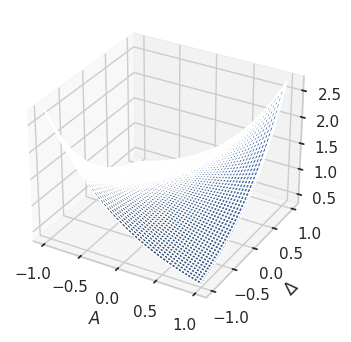

In [ ]:
def discretize(a, b, delta):
    da = delta * a
    a_ = torch.exp(da)
    b_ = b * delta
    return a_, b_
ax = plt.figure().add_subplot(projection='3d')
a = torch.linspace(-1, 1, 100)[None].expand(100, 100)
delta = torch.linspace(-1, 1, 100)[:, None].expand(100, 100)
ax.plot_surface(a.cpu(), delta.cpu(), discretize(a, 1, delta)[0].cpu())
ax.set_xlabel('$A$')
ax.set_ylabel('$\Delta$')

The math looks the same as above. Note the only difference is that we first discretize before running the recurrence.

In [ ]:
x = arange(SEQLEN)
a, b, c, delta = [ones(SEQLEN) for _ in range(4)]
delta[:] = 0.01
def simple_mamba_torch(x, a, b, c, delta):
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(len(x)):
        h = a_[k] * h + b_[k] * x[k]
        y.append(c[k] * h)
    return h, torch.stack(y)

def L(x, a, b, c, delta):
    return simple_mamba_torch(x, a, b, c, delta)[1].sum()

h, y_ = simple_mamba_torch(x, a, b, c, delta)
g = torch.func.grad(L, tuple(range(5)))
dx_, da_, db_, dc_, ddelta_ = g(x_, a, b, c, delta)

If we want to reimplement the standard exponential moving average from before, we can do this. The conversion is:

$$A = \log(\bar{A})/ \Delta = \log(\alpha) / \Delta$$
$$B = \frac{\bar{B}  \Delta A}{\bar{A} - 1} = \frac{(1 - \alpha) \log(\alpha)}{\alpha - 1} = - \log(\alpha)$$

In [ ]:
delt = 0.5
alpha = 0.9
discretize(torch.tensor(alpha).log() / delt, -torch.tensor(alpha).log(), torch.tensor(delt))

(tensor(0.9000), tensor(0.0527))

We will need to port this code to Triton as well. The forward pass is straightforward. However, we also need to write the backwards. (Honestly for this part I just called Wolfram Alpha)

In [ ]:
@triton.jit
def discretize_tt(a, b, delta):
    da = delta * a
    a_ = tl.exp(da)
    b_ = b * delta
    return a_, b_

@triton.jit
def discretize_back(a, b, d, da_, db_):
    da = d * a
    a_ = tl.exp(da)

    da_da = d * a_
    da_ddelta = a * a_

    inter = (b * (da - 1) * a_ + b) / da

    #db_da = 0
    db_db = d
    db_ddelta = b

    return da_ * da_da, db_ * db_db, da_ * da_ddelta + db_ * db_ddelta

### Simple Implementation



Now we can actually implement the Mamba scan. We can start by doing this for 1 dimension. The code is going to look very familar at this point.

In [ ]:
@triton.jit
def mamba1_tt(X, dX, A, dA, B, dB, C, dC, Delta, dDelta, Y, dY, K: tl.constexpr):
    Ks = tl.arange(0, K)
    a, b, c = ssm_load(Ks, A, B, C)
    x = tl.load(X + Ks)
    dy = tl.load(dY + Ks)
    delta = tl.load(Delta + Ks)
    id2 = Ks * 0.0

    # Compute Forward
    a_, b_ = discretize_tt(a, b, delta)
    h1, h2 = ssm_scan(a_, b_ * x, id2)
    y = c * h2
    tl.store(Y + Ks, y)

    # Compute Backward
    h1, dh = ssm_scan(roll(a_, 0, 1), c * dy, id2, reversed=1)
    rh2 = roll(h2, 0)
    da_ = dh*rh2
    db_ = dh*x
    da, db, ddelta = discretize_back(a, b, delta, da_, db_)

    # Save
    tl.store(dDelta + Ks, ddelta)
    tl.store(dX + Ks, b_ * dh)
    ssm_store(Ks, dA, da, dB, db, dC, h2 * dy)

dx, da, db, dc, ddelta = [zeros(SEQLEN) for _ in range(5)]
y, dy = [ones(SEQLEN) for _ in range(2)]
mamba1_tt[(1,)](x, dx, a, da, b, db, c, dc, delta, ddelta, y, dy, K=SEQLEN)
dx_, da_, db_, dc_, ddelta_ = g(x_, a, b, c, delta)
check(y, y_, dx, dx_, da[-2*K:], da_[-2*K:], db[-2*K:], db_[-2*K:], ddelta[-2*K:], ddelta_[-2*K:])

✔️


As a sanity check let us use it to compute the moving average

<BarContainer object of 128 artists>

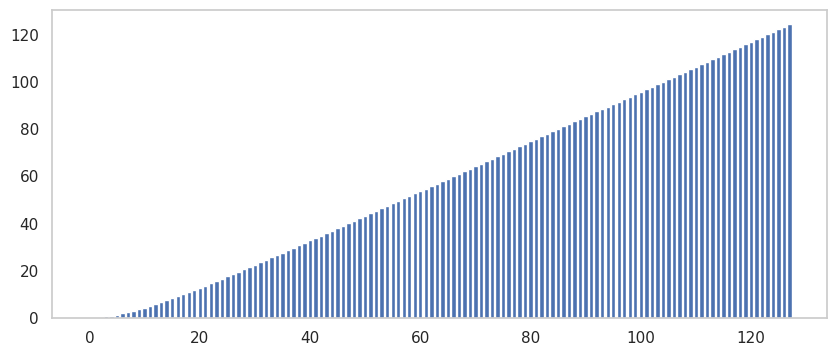

In [ ]:
a = (torch.zeros_like(a) + 0.9).log()
b = -(torch.zeros_like(b) + 0.9).log()
delta = torch.ones_like(delta)
mamba1_tt[(1,)](x, dx, a, da, b, db, c, dc, delta, ddelta, y, dy, K=SEQLEN)
plt.bar(range(SEQLEN), y.cpu())

### Block Implementation

Now let us put it all together!

The final algorithm that we need to implement is going to be a version of this that is extremely heavily batched.

This picture describes the shapes.

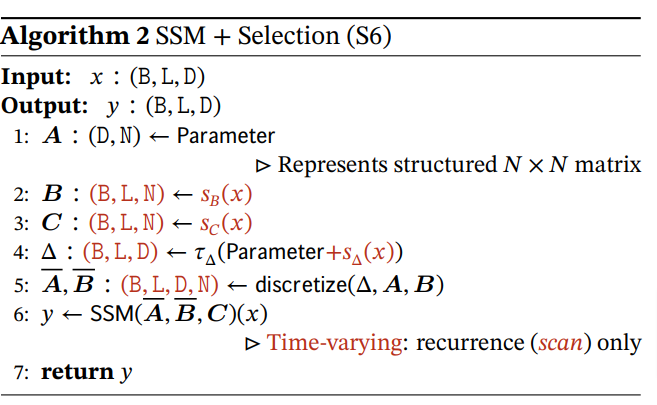

First let us translate this to naive pytorch code. Most of the work is in structuring the shapes.

In [ ]:
def mamba_torch(x, a, b, c, delta):
    "PyTorch Implementation"
    y = []
    h = 0
    a_, b_ = discretize(a, b, delta)
    for k in range(x.shape[-1]):
        h = a_[..., k] * h + b_[..., k] * x[..., k]
        y.append((c[..., k] * h).sum(1, keepdim=True))
    return h, torch.stack(y, -1)

Much of the triton code is in loading in exactly these shapes. You'll note that once things are loaded the core loop looks exactly like Part 3 and Part 4.

In [ ]:


@triton.jit
def mamba_tt(X, dX, A, dA, B, dB, C, dC, Delta, dDelta,
             H_0, dH_0, Y, dY, H, dH,
             back:tl.constexpr,
             step:tl.constexpr,
             L: tl.constexpr, K: tl.constexpr, D_step: tl.constexpr,
             D:tl.constexpr, N: tl.constexpr):
    # Setup
    pid = tl.program_id(0)
    bid = tl.program_id(1)
    kid = pid * K
    nH = tl.num_programs(0)
    Ba = tl.num_programs(1)
    Ks = tl.arange(0, K)[None, None, :] # 1 x 1 x K
    Ns = tl.arange(0, N)[:, None, None] # N x 1 x 1
    Nx1xK = bid*N*L + Ns*L + (Ks + kid)



    # Load forward
    b = tl.load(B + Nx1xK)
    c = tl.load(C + Nx1xK)
    db_out = tl.zeros_like(b)
    dc_out = tl.zeros_like(c)

    Ds = tl.arange(0, D_step)[None, :, None] # 1 x D x 1

    for did in range(0, D // D_step):
        DxK = bid*D*L + Ds*L + Ks + kid
        NxDx1 = bid*N*D + Ns*D + Ds
        a = tl.load(A + NxDx1)
        NxDx1_H = bid*N*D*nH + Ns*D*nH + Ds*nH + pid
        h_off = Ba*N*D*nH

        # Load forward
        delta = tl.load(Delta + DxK)
        x = tl.load(X + DxK)
        a_, b_ = discretize_tt(a, b, delta)

        if step == 2:
            h2_0 = tl.load(H_0 + 1*h_off + NxDx1_H) * (Ks == 0)
        else:
            h2_0 = tl.zeros_like(a_)
        # Compute Forward
        h1, h2 = ssm_scan(a_, b_ * x, h2_0, dim=2)
        y = tl.sum(c * h2, 0, 1)
        if step == 1:
            tl.store(H + 0 * h_off + NxDx1_H + 0*Ks, h1, Ks==K-1)
            tl.store(H + 1 * h_off + NxDx1_H + 0*Ks, h2, Ks==K-1)
        if step == 2:
            tl.store(Y + DxK, y)

        # #Compute backward
        if back == 1:
            # Load Backward
            dy = tl.load(dY + DxK)
            dh2_0 = tl.load(dH_0 + 1*h_off + NxDx1_H) * (Ks==K-1)
            delta_shift = tl.load(Delta + DxK + 1, (Ks + kid) < L - 1, 0)
            a_s, _ = discretize_tt(a, b, delta_shift)
            dh1, dh = ssm_scan(a_s, c * dy, dh2_0, reversed=1, dim=2)
            if step == 1:
                tl.store(dH + 0*h_off + NxDx1_H + 0*Ks, dh1, Ks == 0)
                tl.store(dH + 1*h_off + NxDx1_H + 0*Ks, dh, Ks == 0)

        if back == 1 and step == 2:
            dc = tl.sum(h2 * dy, 1, 1) # N x K
            rh2 = roll(h2, 2)
            rh2 = h2_0 * (Ks == 0) + rh2 * (Ks > 0)
            da, db, ddelta = discretize_back(a, b, delta, dh * rh2, dh * x)

            # Save (sums keep_dims=1)
            tl.store(dX + DxK, tl.sum(b_ * dh, 0, 1))
            tl.store(dA + NxDx1_H, tl.sum(da, 2, 1))
            tl.store(dDelta + DxK, tl.sum(ddelta, 0, 1))
            db_out = db_out + tl.sum(db, 1, 1)
            dc_out = dc_out + dc
        Ds = Ds + D_step

    if back==1 and step==2:
        tl.store(dB + Nx1xK, db_out)
        tl.store(dC + Nx1xK, dc_out)


We can now test this with our same code setup.

In [ ]:
def create(S = 128, Ba = 2, D = 4, N = 4):
    x = rand((Ba, 1, D, S))
    a = -ones((Ba, N, D, 1))
    b = ones((Ba, N, 1, S)) * 0.1
    c = rand((Ba, N, 1, S)) * 0.1
    delta = rand((Ba, 1, D, S)) * 0.1
    return x, a, b, c, delta

def mamba(x, a, b, c, delta, K=16, D_step=2):
    Ba = x.shape[0]
    N = a.shape[1]
    D = delta.shape[2]
    SEQLEN = x.shape[-1]
    BLOCKS = SEQLEN // K
    dx, da, db, dc, ddelta = [torch.zeros_like(b) for b in [x,a,b,c,delta]]
    da = zeros(Ba, N, D, BLOCKS)
    y, dy = [ones(Ba, 1, D, SEQLEN) for _ in range(2)]
    h, dh = [zeros(2, 2, Ba, N, D, BLOCKS) for _ in range(2)]
    assert BLOCKS == SEQLEN // K
    assert D % D_step == 0
    mamba_tt[(BLOCKS, Ba)](x, dx, a, da, b, db, c, dc, delta, ddelta, h[0], dh[0], y, dy, h[0], dh[0], back=1, step=1, L=SEQLEN, K=K, D_step=D_step, D=D, N=N)
    reduce(h, False, Ba * N * D)
    reduce(dh, True, Ba * N * D)
    mamba_tt[(BLOCKS, Ba)](x, dx, a, da, b, db, c, dc, delta, ddelta, h[1], dh[1], y, dy, h[1], dh[1], back=1, step=2, L=SEQLEN, K=K, D_step=D_step, D=D, N=N)
    return y, dx, da.sum(-1, keepdim=True), db, dc, ddelta

x, a, b, c, delta = create()
y, dx, da, db, dc, ddelta = mamba(x, a, b, c, delta)
for v in [x, a, b, c, delta]:
    v.requires_grad_()
_, y_ = mamba_torch(x, a, b, c, delta)
y_.sum().backward()
check(y, y_, da, a.grad, dx, x.grad, dc, c.grad, db, b.grad, prec=1e-3)


✔️


Now let us confirm that we are the same as in the Mamba repo.

In [ ]:
import selective_scan_cuda
y_from_repo = selective_scan_cuda.fwd(x.squeeze(1), delta.squeeze(1), a[0].squeeze(-1).T, b.squeeze(-2)[:, None, :, :], c.squeeze(-2)[:, None, :, :], None, None, None, False)

check(y.squeeze(1), y_from_repo[0])

✔️


Okay, now we have a running kernel. It's pretty fast in practice, but still a bit slower than the Mamba implementation unfortunately.

In [ ]:
y_ = mamba(*create(S = 2048, Ba = 8, D = 1024, N=4), K = 128, D_step=16)

Woot! Fully implemented and running.

Okay let us end here. We have achieved our first goal of getting the full version of the Mamba / S6 algorithm running. I hope to add a future version where we go into more detail about profiling and speeding up the core algorithm. Hopefully with those we can get running faster.

Cheers,
Sasha